In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

##########################################
# 数据读取与处理
##########################################
df = pd.read_csv("/content/drive/MyDrive/AAPL.csv", parse_dates=["DateTime"], index_col="DateTime")
df = df.sort_index()
df = df.ffill()  # 前向填充

df = df[(df.index >= '2000-01-01') & (df.index <= '2010-01-01')]

df.columns = df.columns.str.lower()
feature_cols = ["open", "high", "low", "close", "volume"]

agg_dict = {
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
    "volume": "sum"
}

df_15min = df.resample("15T").agg(agg_dict).dropna(how='any')
df_30min = df.resample("30T").agg(agg_dict).dropna(how='any')
df_60min = df.resample("60T").agg(agg_dict).dropna(how='any')

df_15min = df_15min.rename(columns=lambda c: c.lower()+"_15")
df_30min = df_30min.rename(columns=lambda c: c.lower()+"_30")
df_60min = df_60min.rename(columns=lambda c: c.lower()+"_60")

df_all = df_15min.join(df_30min, how="inner").join(df_60min, how="inner")
print("df_all columns:", df_all.columns)

short_cols = [col+"_15" for col in feature_cols]
mid_cols = [col+"_30" for col in feature_cols]
long_cols = [col+"_60" for col in feature_cols]

all_feature_cols = short_cols + mid_cols + long_cols

<ipython-input-2-7bc54823bcac>:31: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_15min = df.resample("15T").agg(agg_dict).dropna(how='any')
<ipython-input-2-7bc54823bcac>:32: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_30min = df.resample("30T").agg(agg_dict).dropna(how='any')
<ipython-input-2-7bc54823bcac>:33: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_60min = df.resample("60T").agg(agg_dict).dropna(how='any')


df_all columns: Index(['open_15', 'high_15', 'low_15', 'close_15', 'volume_15', 'open_30',
       'high_30', 'low_30', 'close_30', 'volume_30', 'open_60', 'high_60',
       'low_60', 'close_60', 'volume_60'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-3-9454d147e54d>:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(target_seq, dtype=torch.float32),


Epoch [1/10], Average Loss: 0.0010
Epoch [2/10], Average Loss: 0.0002
Epoch [3/10], Average Loss: 0.0002
Epoch [4/10], Average Loss: 0.0001
Epoch [5/10], Average Loss: 0.0001
Epoch [6/10], Average Loss: 0.0001
Epoch [7/10], Average Loss: 0.0001
Epoch [8/10], Average Loss: 0.0001
Epoch [9/10], Average Loss: 0.0001
Epoch [10/10], Average Loss: 0.0001
Evaluation Results on Denormalized Scale (Test Set):
MSE: 0.0181
RMSE: 0.1345
MAE: 0.1163
R²: 0.9907


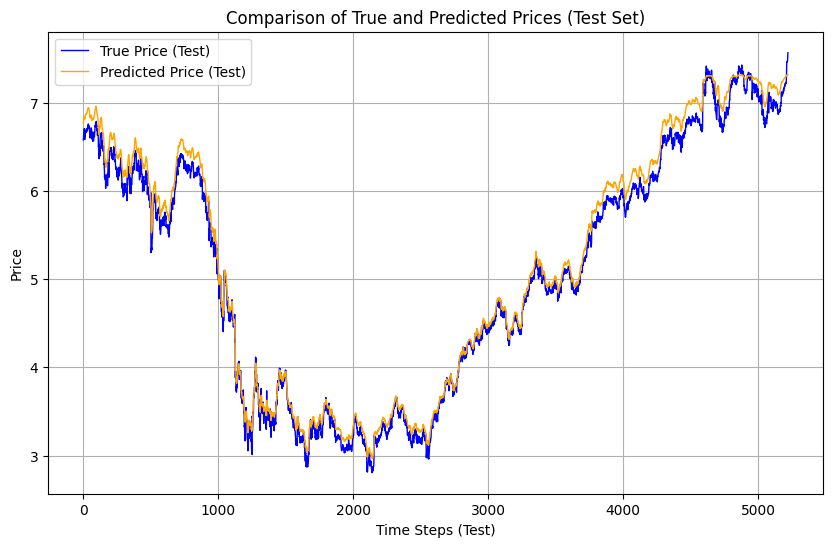

In [ ]:
# 使用MinMaxScaler进行归一化
scaler = MinMaxScaler()
df_all[all_feature_cols] = scaler.fit_transform(df_all[all_feature_cols])

# 数据划分为训练集和测试集（如80%训练，20%测试）
N = len(df_all)
train_ratio = 0.8
train_size = int(N * train_ratio)

train_df = df_all.iloc[:train_size]
test_df = df_all.iloc[train_size:]

train_short_data = train_df[short_cols].values
train_mid_data = train_df[mid_cols].values
train_long_data = train_df[long_cols].values
train_close_15_series = train_df["close_15"].values

test_short_data = test_df[short_cols].values
test_mid_data = test_df[mid_cols].values
test_long_data = test_df[long_cols].values
test_close_15_series = test_df["close_15"].values

seq_len_short = 16
seq_len_mid = 32
seq_len_long = 64

##########################################
# 定义Dataset
##########################################
class MultiScaleStockDataset(Dataset):
    def __init__(self, short_data, mid_data, long_data, close_label,
                 seq_len_short, seq_len_mid, seq_len_long):
        super().__init__()
        self.short_data = short_data
        self.mid_data = mid_data
        self.long_data = long_data
        self.close_label = close_label
        self.seq_len_short = seq_len_short
        self.seq_len_mid = seq_len_mid
        self.seq_len_long = seq_len_long

        self.length = len(short_data) - max(seq_len_short, seq_len_mid, seq_len_long) - 1
        if self.length < 1:
            raise ValueError("Not enough data to form a single sample.")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        start = idx
        end_short = start + self.seq_len_short
        end_mid = start + self.seq_len_mid
        end_long = start + self.seq_len_long

        target_idx = end_short
        short_seq = self.short_data[start:end_short]
        mid_seq = self.mid_data[start:end_mid]
        long_seq = self.long_data[start:end_long]

        label = self.close_label[target_idx]
        # target_seq = torch.zeros(1, short_seq.shape[1])  # decoder输入为0
        # 将 target_seq 设置为短期序列的最后一个时间步的特征，而不是全零
        target_seq = torch.tensor(short_seq[-1], dtype=torch.float32).unsqueeze(0)  # shape: (1, num_features)


        return (torch.tensor(short_seq, dtype=torch.float32),
                torch.tensor(mid_seq, dtype=torch.float32),
                torch.tensor(long_seq, dtype=torch.float32),
                torch.tensor(target_seq, dtype=torch.float32),
                torch.tensor([label], dtype=torch.float32))


train_dataset = MultiScaleStockDataset(train_short_data, train_mid_data, train_long_data, train_close_15_series,
                                       seq_len_short, seq_len_mid, seq_len_long)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = MultiScaleStockDataset(test_short_data, test_mid_data, test_long_data, test_close_15_series,
                                      seq_len_short, seq_len_mid, seq_len_long)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

##########################################
# 模型定义
##########################################
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x

class MultiScaleTransformer(nn.Module):
    def __init__(self,
                 feature_dim,
                 d_model,
                 nhead,
                 num_encoder_layers,
                 num_decoder_layers,
                 output_dim,
                 mlp_hidden_dim=128):
        super(MultiScaleTransformer, self).__init__()

        self.embedding = nn.Linear(feature_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead)

        self.short_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.short_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.mid_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.mid_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.long_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.long_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.conv_fusion = nn.Conv1d(in_channels=3*d_model, out_channels=d_model, kernel_size=1)

        self.mlp = nn.Sequential(
            nn.Linear(d_model, mlp_hidden_dim),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, output_dim)
        )

    def forward(self, short_input, mid_input, long_input, target_seq):
        short_embed = self.embedding(short_input)
        mid_embed = self.embedding(mid_input)
        long_embed = self.embedding(long_input)

        tgt_embed = self.embedding(target_seq)
        tgt_embed = self.pos_encoder(tgt_embed).permute(1,0,2)

        short_embed = self.pos_encoder(short_embed).permute(1,0,2)
        mid_embed = self.pos_encoder(mid_embed).permute(1,0,2)
        long_embed = self.pos_encoder(long_embed).permute(1,0,2)

        short_enc = self.short_encoder(short_embed)
        mid_enc = self.mid_encoder(mid_embed)
        long_enc = self.long_encoder(long_embed)

        short_dec = self.short_decoder(tgt=tgt_embed, memory=short_enc)
        mid_dec = self.mid_decoder(tgt=tgt_embed, memory=mid_enc)
        long_dec = self.long_decoder(tgt=tgt_embed, memory=long_enc)

        short_feat = short_dec[0]
        mid_feat = mid_dec[0]
        long_feat = long_dec[0]

        fusion_feat = torch.cat([short_feat, mid_feat, long_feat], dim=-1)
        fusion_feat = fusion_feat.unsqueeze(-1)
        fusion_feat = self.conv_fusion(fusion_feat)
        fusion_feat = fusion_feat.squeeze(-1)

        output = self.mlp(fusion_feat)
        return output

##########################################
# 训练
##########################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_dim = len(feature_cols) # now 4
d_model = 64
nhead = 4
num_encoder_layers = 2
num_decoder_layers = 2
output_dim = 1
lr = 1e-4
epochs = 10

model = MultiScaleTransformer(feature_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model.train()
for epoch in range(1, epochs+1):
    epoch_loss = 0.0
    batch_count = 0
    for i, (short_seq, mid_seq, long_seq, tgt_seq, label) in enumerate(train_dataloader, start=1):
        short_seq = short_seq.to(device)
        mid_seq = mid_seq.to(device)
        long_seq = long_seq.to(device)
        tgt_seq = tgt_seq.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output = model(short_seq, mid_seq, long_seq, tgt_seq)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * short_seq.size(0)
        batch_count += short_seq.size(0)

    avg_loss = epoch_loss / batch_count
    print(f"Epoch [{epoch}/{epochs}], Average Loss: {avg_loss:.4f}")

##########################################
# 在测试集上进行预测和评估
##########################################
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for (short_seq, mid_seq, long_seq, tgt_seq, label) in test_dataloader:
        short_seq = short_seq.to(device)
        mid_seq = mid_seq.to(device)
        long_seq = long_seq.to(device)
        tgt_seq = tgt_seq.to(device)
        label = label.to(device)

        pred = model(short_seq, mid_seq, long_seq, tgt_seq)
        all_preds.append(pred.cpu().numpy())
        all_labels.append(label.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

num_samples = all_preds.shape[0]
num_features = len(all_feature_cols)
close_15_index = all_feature_cols.index("close_15")

preds_extended = np.zeros((num_samples, num_features))
labels_extended = np.zeros((num_samples, num_features))

preds_extended[:, close_15_index] = all_preds[:, 0]
labels_extended[:, close_15_index] = all_labels[:, 0]

inv_preds = scaler.inverse_transform(preds_extended)[:, close_15_index]
inv_labels = scaler.inverse_transform(labels_extended)[:, close_15_index]

# 计算指标
mse = mean_squared_error(inv_labels, inv_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(inv_labels, inv_preds)
r2 = r2_score(inv_labels, inv_preds)

print("Evaluation Results on Denormalized Scale (Test Set):")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# 画出测试集部分的对比图
plt.figure(figsize=(10,6))
plt.plot(inv_labels, label="True Price (Test)", color='blue', linewidth=1.0)
plt.plot(inv_preds, label="Predicted Price (Test)", color='orange', linewidth=1.0)
plt.title("Comparison of True and Predicted Prices (Test Set)")
plt.xlabel("Time Steps (Test)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
# 可根据需要调整显示范围，例如：
# plt.ylim(20000, 22000)
plt.show()

In [ ]:
APPL_inv_preds = inv_preds

In [ ]:
APPL_inv_preds

array([6.77112607, 6.79148041, 6.80970517, ..., 7.32098582, 7.32082275,
       7.32055479])

<ipython-input-10-12e8571b4efc>:30: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_15min = df.resample("15T").agg(agg_dict).dropna(how='any')
<ipython-input-10-12e8571b4efc>:31: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_30min = df.resample("30T").agg(agg_dict).dropna(how='any')
<ipython-input-10-12e8571b4efc>:32: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_60min = df.resample("60T").agg(agg_dict).dropna(how='any')
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-10-12e8571b4efc>:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

df_all columns: Index(['open_15', 'high_15', 'low_15', 'close_15', 'open_30', 'high_30',
       'low_30', 'close_30', 'open_60', 'high_60', 'low_60', 'close_60'],
      dtype='object')
Epoch [1/10], Average Loss: 0.0575
Epoch [2/10], Average Loss: 0.0094
Epoch [3/10], Average Loss: 0.0068
Epoch [4/10], Average Loss: 0.0049
Epoch [5/10], Average Loss: 0.0040
Epoch [6/10], Average Loss: 0.0036
Epoch [7/10], Average Loss: 0.0030
Epoch [8/10], Average Loss: 0.0031
Epoch [9/10], Average Loss: 0.0029
Epoch [10/10], Average Loss: 0.0022
Evaluation Results on STANDARDIZED Data (Test Set):
MSE: 0.0028
RMSE: 0.0525
MAE: 0.0486
R²: 0.9525


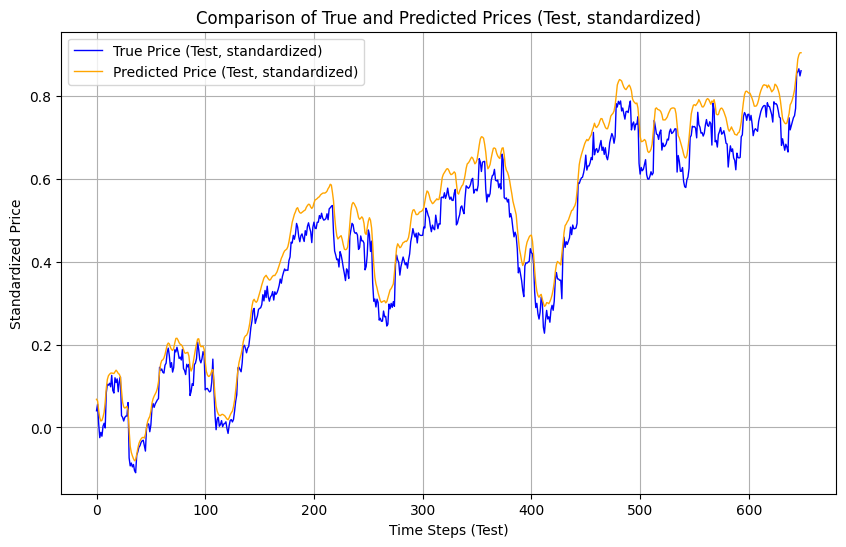

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

##########################################
# 数据读取与处理
##########################################
df = pd.read_csv("/content/drive/MyDrive/NDX.csv", parse_dates=["DateTime"], index_col="DateTime")
df = df.sort_index()
df = df.ffill()  # 前向填充

df = df[(df.index >= '2000-01-01') & (df.index <= '2010-01-01')]

df.columns = df.columns.str.lower()
feature_cols = ["open", "high", "low", "close"]

agg_dict = {
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
}

df_15min = df.resample("15T").agg(agg_dict).dropna(how='any')
df_30min = df.resample("30T").agg(agg_dict).dropna(how='any')
df_60min = df.resample("60T").agg(agg_dict).dropna(how='any')

df_15min = df_15min.rename(columns=lambda c: c.lower()+"_15")
df_30min = df_30min.rename(columns=lambda c: c.lower()+"_30")
df_60min = df_60min.rename(columns=lambda c: c.lower()+"_60")

df_all = df_15min.join(df_30min, how="inner").join(df_60min, how="inner")
print("df_all columns:", df_all.columns)

short_cols = [col+"_15" for col in feature_cols]
mid_cols = [col+"_30" for col in feature_cols]
long_cols = [col+"_60" for col in feature_cols]

all_feature_cols = short_cols + mid_cols + long_cols

# 使用StandardScaler进行标准化
scaler = StandardScaler()
df_all[all_feature_cols] = scaler.fit_transform(df_all[all_feature_cols])

N = len(df_all)
train_ratio = 0.8
train_size = int(N * train_ratio)

train_df = df_all.iloc[:train_size]
test_df = df_all.iloc[train_size:]

train_short_data = train_df[short_cols].values
train_mid_data = train_df[mid_cols].values
train_long_data = train_df[long_cols].values
train_close_15_series = train_df["close_15"].values  # 标准化后的close_15

test_short_data = test_df[short_cols].values
test_mid_data = test_df[mid_cols].values
test_long_data = test_df[long_cols].values
test_close_15_series = test_df["close_15"].values  # 标准化后的close_15

seq_len_short = 16
seq_len_mid = 32
seq_len_long = 64

##########################################
# 定义Dataset（不变）
##########################################
class MultiScaleStockDataset(Dataset):
    def __init__(self, short_data, mid_data, long_data, close_label,
                 seq_len_short, seq_len_mid, seq_len_long):
        super().__init__()
        self.short_data = short_data
        self.mid_data = mid_data
        self.long_data = long_data
        self.close_label = close_label
        self.seq_len_short = seq_len_short
        self.seq_len_mid = seq_len_mid
        self.seq_len_long = seq_len_long

        self.length = len(short_data) - max(seq_len_short, seq_len_mid, seq_len_long) - 1
        if self.length < 1:
            raise ValueError("Not enough data to form a single sample.")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        start = idx
        end_short = start + self.seq_len_short
        end_mid = start + self.seq_len_mid
        end_long = start + self.seq_len_long

        target_idx = end_short
        short_seq = self.short_data[start:end_short]
        mid_seq = self.mid_data[start:end_mid]
        long_seq = self.long_data[start:end_long]

        label = self.close_label[target_idx]
        target_seq = torch.zeros(1, short_seq.shape[1])  # decoder输入为0

        return (torch.tensor(short_seq, dtype=torch.float32),
                torch.tensor(mid_seq, dtype=torch.float32),
                torch.tensor(long_seq, dtype=torch.float32),
                torch.tensor(target_seq, dtype=torch.float32),
                torch.tensor([label], dtype=torch.float32))

train_dataset = MultiScaleStockDataset(train_short_data, train_mid_data, train_long_data, train_close_15_series,
                                       seq_len_short, seq_len_mid, seq_len_long)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = MultiScaleStockDataset(test_short_data, test_mid_data, test_long_data, test_close_15_series,
                                      seq_len_short, seq_len_mid, seq_len_long)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

##########################################
# 模型定义（不变）
##########################################
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x

class MultiScaleTransformer(nn.Module):
    def __init__(self,
                 feature_dim,
                 d_model,
                 nhead,
                 num_encoder_layers,
                 num_decoder_layers,
                 output_dim,
                 mlp_hidden_dim=128):
        super(MultiScaleTransformer, self).__init__()

        self.embedding = nn.Linear(feature_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead)

        self.short_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.short_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.mid_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.mid_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.long_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.long_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.conv_fusion = nn.Conv1d(in_channels=3*d_model, out_channels=d_model, kernel_size=1)

        self.mlp = nn.Sequential(
            nn.Linear(d_model, mlp_hidden_dim),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, output_dim)
        )

    def forward(self, short_input, mid_input, long_input, target_seq):
        short_embed = self.embedding(short_input)
        mid_embed = self.embedding(mid_input)
        long_embed = self.embedding(long_input)

        tgt_embed = self.embedding(target_seq)
        tgt_embed = self.pos_encoder(tgt_embed).permute(1,0,2)

        short_embed = self.pos_encoder(short_embed).permute(1,0,2)
        mid_embed = self.pos_encoder(mid_embed).permute(1,0,2)
        long_embed = self.pos_encoder(long_embed).permute(1,0,2)

        short_enc = self.short_encoder(short_embed)
        mid_enc = self.mid_encoder(mid_embed)
        long_enc = self.long_encoder(long_embed)

        short_dec = self.short_decoder(tgt=tgt_embed, memory=short_enc)
        mid_dec = self.mid_decoder(tgt=tgt_embed, memory=mid_enc)
        long_dec = self.long_decoder(tgt=tgt_embed, memory=long_enc)

        short_feat = short_dec[0]
        mid_feat = mid_dec[0]
        long_feat = long_dec[0]

        fusion_feat = torch.cat([short_feat, mid_feat, long_feat], dim=-1)
        fusion_feat = fusion_feat.unsqueeze(-1)
        fusion_feat = self.conv_fusion(fusion_feat)
        fusion_feat = fusion_feat.squeeze(-1)

        output = self.mlp(fusion_feat)
        return output

##########################################
# Training
##########################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_dim = len(feature_cols) # now 4
d_model = 64
nhead = 4
num_encoder_layers = 2
num_decoder_layers = 2
output_dim = 1
lr = 1e-4
epochs = 10

model = MultiScaleTransformer(feature_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model.train()
for epoch in range(1, epochs+1):
    epoch_loss = 0.0
    batch_count = 0
    for i, (short_seq, mid_seq, long_seq, tgt_seq, label) in enumerate(train_dataloader, start=1):
        short_seq = short_seq.to(device)
        mid_seq = mid_seq.to(device)
        long_seq = long_seq.to(device)
        tgt_seq = tgt_seq.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output = model(short_seq, mid_seq, long_seq, tgt_seq)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * short_seq.size(0)
        batch_count += short_seq.size(0)

    avg_loss = epoch_loss / batch_count
    print(f"Epoch [{epoch}/{epochs}], Average Loss: {avg_loss:.4f}")

##########################################
# 在测试集上进行预测和评估（标准化空间）
##########################################
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for (short_seq, mid_seq, long_seq, tgt_seq, label) in test_dataloader:
        short_seq = short_seq.to(device)
        mid_seq = mid_seq.to(device)
        long_seq = long_seq.to(device)
        tgt_seq = tgt_seq.to(device)
        label = label.to(device)

        pred = model(short_seq, mid_seq, long_seq, tgt_seq)
        all_preds.append(pred.cpu().numpy())
        all_labels.append(label.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0).flatten()
all_labels = np.concatenate(all_labels, axis=0).flatten()

# 此时all_preds和all_labels都是在标准化后的空间中
mse = mean_squared_error(all_labels, all_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_labels, all_preds)
r2 = r2_score(all_labels, all_preds)

print("Evaluation Results on STANDARDIZED Data (Test Set):")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# 绘图对比真实值与预测值（标准化后的值）
plt.figure(figsize=(10,6))
plt.plot(all_labels, label="True Price (Test, standardized)", color='blue', linewidth=1.0)
plt.plot(all_preds, label="Predicted Price (Test, standardized)", color='orange', linewidth=1.0)
plt.title("Comparison of True and Predicted Prices (Test, standardized)")
plt.xlabel("Time Steps (Test)")
plt.ylabel("Standardized Price")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
Nasdaq_100_inv_preds = all_preds

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

##########################################
# 数据读取与处理
##########################################
df = pd.read_csv("/content/drive/MyDrive/PEP.csv", parse_dates=["DateTime"], index_col="DateTime")
df = df.sort_index()
df = df.ffill()  # 前向填充

df = df[(df.index >= '2000-01-01') & (df.index <= '2010-01-01')]

df.columns = df.columns.str.lower()
feature_cols = ["open", "high", "low", "close", "volume"]

agg_dict = {
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
    "volume": "sum"
}

df_15min = df.resample("15T").agg(agg_dict).dropna(how='any')
df_30min = df.resample("30T").agg(agg_dict).dropna(how='any')
df_60min = df.resample("60T").agg(agg_dict).dropna(how='any')

df_15min = df_15min.rename(columns=lambda c: c.lower()+"_15")
df_30min = df_30min.rename(columns=lambda c: c.lower()+"_30")
df_60min = df_60min.rename(columns=lambda c: c.lower()+"_60")

df_all = df_15min.join(df_30min, how="inner").join(df_60min, how="inner")
print("df_all columns:", df_all.columns)

short_cols = [col+"_15" for col in feature_cols]
mid_cols = [col+"_30" for col in feature_cols]
long_cols = [col+"_60" for col in feature_cols]

all_feature_cols = short_cols + mid_cols + long_cols


df_all columns: Index(['open_15', 'high_15', 'low_15', 'close_15', 'volume_15', 'open_30',
       'high_30', 'low_30', 'close_30', 'volume_30', 'open_60', 'high_60',
       'low_60', 'close_60', 'volume_60'],
      dtype='object')


<ipython-input-102-818bd7d5b777>:31: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_15min = df.resample("15T").agg(agg_dict).dropna(how='any')
<ipython-input-102-818bd7d5b777>:32: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_30min = df.resample("30T").agg(agg_dict).dropna(how='any')
<ipython-input-102-818bd7d5b777>:33: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_60min = df.resample("60T").agg(agg_dict).dropna(how='any')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-103-9454d147e54d>:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(target_seq, dtype=torch.float32),


Epoch [1/10], Average Loss: 0.0010
Epoch [2/10], Average Loss: 0.0003
Epoch [3/10], Average Loss: 0.0002
Epoch [4/10], Average Loss: 0.0002
Epoch [5/10], Average Loss: 0.0001
Epoch [6/10], Average Loss: 0.0001
Epoch [7/10], Average Loss: 0.0001
Epoch [8/10], Average Loss: 0.0001
Epoch [9/10], Average Loss: 0.0001
Epoch [10/10], Average Loss: 0.0001
Evaluation Results on Denormalized Scale (Test Set):
MSE: 0.7001
RMSE: 0.8367
MAE: 0.7055
R²: 0.9873


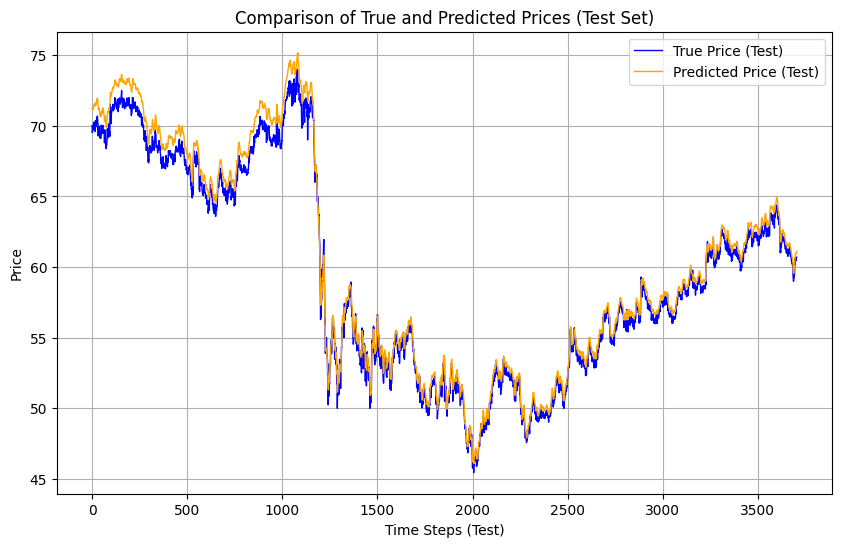

In [ ]:
# 使用MinMaxScaler进行归一化
scaler = MinMaxScaler()
df_all[all_feature_cols] = scaler.fit_transform(df_all[all_feature_cols])

# 数据划分为训练集和测试集（如80%训练，20%测试）
N = len(df_all)
train_ratio = 0.8
train_size = int(N * train_ratio)

train_df = df_all.iloc[:train_size]
test_df = df_all.iloc[train_size:]

train_short_data = train_df[short_cols].values
train_mid_data = train_df[mid_cols].values
train_long_data = train_df[long_cols].values
train_close_15_series = train_df["close_15"].values

test_short_data = test_df[short_cols].values
test_mid_data = test_df[mid_cols].values
test_long_data = test_df[long_cols].values
test_close_15_series = test_df["close_15"].values

seq_len_short = 16
seq_len_mid = 32
seq_len_long = 64

##########################################
# 定义Dataset
##########################################
class MultiScaleStockDataset(Dataset):
    def __init__(self, short_data, mid_data, long_data, close_label,
                 seq_len_short, seq_len_mid, seq_len_long):
        super().__init__()
        self.short_data = short_data
        self.mid_data = mid_data
        self.long_data = long_data
        self.close_label = close_label
        self.seq_len_short = seq_len_short
        self.seq_len_mid = seq_len_mid
        self.seq_len_long = seq_len_long

        self.length = len(short_data) - max(seq_len_short, seq_len_mid, seq_len_long) - 1
        if self.length < 1:
            raise ValueError("Not enough data to form a single sample.")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        start = idx
        end_short = start + self.seq_len_short
        end_mid = start + self.seq_len_mid
        end_long = start + self.seq_len_long

        target_idx = end_short
        short_seq = self.short_data[start:end_short]
        mid_seq = self.mid_data[start:end_mid]
        long_seq = self.long_data[start:end_long]

        label = self.close_label[target_idx]
        # target_seq = torch.zeros(1, short_seq.shape[1])  # decoder输入为0
        # 将 target_seq 设置为短期序列的最后一个时间步的特征，而不是全零
        target_seq = torch.tensor(short_seq[-1], dtype=torch.float32).unsqueeze(0)  # shape: (1, num_features)


        return (torch.tensor(short_seq, dtype=torch.float32),
                torch.tensor(mid_seq, dtype=torch.float32),
                torch.tensor(long_seq, dtype=torch.float32),
                torch.tensor(target_seq, dtype=torch.float32),
                torch.tensor([label], dtype=torch.float32))


train_dataset = MultiScaleStockDataset(train_short_data, train_mid_data, train_long_data, train_close_15_series,
                                       seq_len_short, seq_len_mid, seq_len_long)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = MultiScaleStockDataset(test_short_data, test_mid_data, test_long_data, test_close_15_series,
                                      seq_len_short, seq_len_mid, seq_len_long)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

##########################################
# 模型定义
##########################################
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x

class MultiScaleTransformer(nn.Module):
    def __init__(self,
                 feature_dim,
                 d_model,
                 nhead,
                 num_encoder_layers,
                 num_decoder_layers,
                 output_dim,
                 mlp_hidden_dim=128):
        super(MultiScaleTransformer, self).__init__()

        self.embedding = nn.Linear(feature_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead)

        self.short_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.short_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.mid_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.mid_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.long_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.long_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.conv_fusion = nn.Conv1d(in_channels=3*d_model, out_channels=d_model, kernel_size=1)

        self.mlp = nn.Sequential(
            nn.Linear(d_model, mlp_hidden_dim),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, output_dim)
        )

    def forward(self, short_input, mid_input, long_input, target_seq):
        short_embed = self.embedding(short_input)
        mid_embed = self.embedding(mid_input)
        long_embed = self.embedding(long_input)

        tgt_embed = self.embedding(target_seq)
        tgt_embed = self.pos_encoder(tgt_embed).permute(1,0,2)

        short_embed = self.pos_encoder(short_embed).permute(1,0,2)
        mid_embed = self.pos_encoder(mid_embed).permute(1,0,2)
        long_embed = self.pos_encoder(long_embed).permute(1,0,2)

        short_enc = self.short_encoder(short_embed)
        mid_enc = self.mid_encoder(mid_embed)
        long_enc = self.long_encoder(long_embed)

        short_dec = self.short_decoder(tgt=tgt_embed, memory=short_enc)
        mid_dec = self.mid_decoder(tgt=tgt_embed, memory=mid_enc)
        long_dec = self.long_decoder(tgt=tgt_embed, memory=long_enc)

        short_feat = short_dec[0]
        mid_feat = mid_dec[0]
        long_feat = long_dec[0]

        fusion_feat = torch.cat([short_feat, mid_feat, long_feat], dim=-1)
        fusion_feat = fusion_feat.unsqueeze(-1)
        fusion_feat = self.conv_fusion(fusion_feat)
        fusion_feat = fusion_feat.squeeze(-1)

        output = self.mlp(fusion_feat)
        return output

##########################################
# 训练
##########################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_dim = len(feature_cols) # now 4
d_model = 64
nhead = 4
num_encoder_layers = 2
num_decoder_layers = 2
output_dim = 1
lr = 1e-4
epochs = 10

model = MultiScaleTransformer(feature_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model.train()
for epoch in range(1, epochs+1):
    epoch_loss = 0.0
    batch_count = 0
    for i, (short_seq, mid_seq, long_seq, tgt_seq, label) in enumerate(train_dataloader, start=1):
        short_seq = short_seq.to(device)
        mid_seq = mid_seq.to(device)
        long_seq = long_seq.to(device)
        tgt_seq = tgt_seq.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output = model(short_seq, mid_seq, long_seq, tgt_seq)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * short_seq.size(0)
        batch_count += short_seq.size(0)

    avg_loss = epoch_loss / batch_count
    print(f"Epoch [{epoch}/{epochs}], Average Loss: {avg_loss:.4f}")

##########################################
# 在测试集上进行预测和评估
##########################################
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for (short_seq, mid_seq, long_seq, tgt_seq, label) in test_dataloader:
        short_seq = short_seq.to(device)
        mid_seq = mid_seq.to(device)
        long_seq = long_seq.to(device)
        tgt_seq = tgt_seq.to(device)
        label = label.to(device)

        pred = model(short_seq, mid_seq, long_seq, tgt_seq)
        all_preds.append(pred.cpu().numpy())
        all_labels.append(label.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

num_samples = all_preds.shape[0]
num_features = len(all_feature_cols)
close_15_index = all_feature_cols.index("close_15")

preds_extended = np.zeros((num_samples, num_features))
labels_extended = np.zeros((num_samples, num_features))

preds_extended[:, close_15_index] = all_preds[:, 0]
labels_extended[:, close_15_index] = all_labels[:, 0]

inv_preds = scaler.inverse_transform(preds_extended)[:, close_15_index]
inv_labels = scaler.inverse_transform(labels_extended)[:, close_15_index]

# 计算指标
mse = mean_squared_error(inv_labels, inv_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(inv_labels, inv_preds)
r2 = r2_score(inv_labels, inv_preds)

print("Evaluation Results on Denormalized Scale (Test Set):")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# 画出测试集部分的对比图
plt.figure(figsize=(10,6))
plt.plot(inv_labels, label="True Price (Test)", color='blue', linewidth=1.0)
plt.plot(inv_preds, label="Predicted Price (Test)", color='orange', linewidth=1.0)
plt.title("Comparison of True and Predicted Prices (Test Set)")
plt.xlabel("Time Steps (Test)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
# 可根据需要调整显示范围，例如：
# plt.ylim(20000, 22000)
plt.show()

In [ ]:
PEP_inv_preds = inv_preds

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

##########################################
# 数据读取与处理
##########################################
df = pd.read_csv("/content/drive/MyDrive/NVDA.csv", parse_dates=["DateTime"], index_col="DateTime")
df = df.sort_index()
df = df.ffill()  # 前向填充

df = df[(df.index >= '2000-01-01') & (df.index <= '2010-01-01')]

df.columns = df.columns.str.lower()
feature_cols = ["open", "high", "low", "close", "volume"]

agg_dict = {
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
    "volume": "sum"
}

df_15min = df.resample("15T").agg(agg_dict).dropna(how='any')
df_30min = df.resample("30T").agg(agg_dict).dropna(how='any')
df_60min = df.resample("60T").agg(agg_dict).dropna(how='any')

df_15min = df_15min.rename(columns=lambda c: c.lower()+"_15")
df_30min = df_30min.rename(columns=lambda c: c.lower()+"_30")
df_60min = df_60min.rename(columns=lambda c: c.lower()+"_60")

df_all = df_15min.join(df_30min, how="inner").join(df_60min, how="inner")
print("df_all columns:", df_all.columns)

short_cols = [col+"_15" for col in feature_cols]
mid_cols = [col+"_30" for col in feature_cols]
long_cols = [col+"_60" for col in feature_cols]

all_feature_cols = short_cols + mid_cols + long_cols


<ipython-input-59-f5d3fb8c5357>:31: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_15min = df.resample("15T").agg(agg_dict).dropna(how='any')
<ipython-input-59-f5d3fb8c5357>:32: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_30min = df.resample("30T").agg(agg_dict).dropna(how='any')
<ipython-input-59-f5d3fb8c5357>:33: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_60min = df.resample("60T").agg(agg_dict).dropna(how='any')


df_all columns: Index(['open_15', 'high_15', 'low_15', 'close_15', 'volume_15', 'open_30',
       'high_30', 'low_30', 'close_30', 'volume_30', 'open_60', 'high_60',
       'low_60', 'close_60', 'volume_60'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-60-9454d147e54d>:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(target_seq, dtype=torch.float32),


Epoch [1/10], Average Loss: 0.0009
Epoch [2/10], Average Loss: 0.0002
Epoch [3/10], Average Loss: 0.0002
Epoch [4/10], Average Loss: 0.0001
Epoch [5/10], Average Loss: 0.0001
Epoch [6/10], Average Loss: 0.0001
Epoch [7/10], Average Loss: 0.0001
Epoch [8/10], Average Loss: 0.0001
Epoch [9/10], Average Loss: 0.0001
Epoch [10/10], Average Loss: 0.0001
Evaluation Results on Denormalized Scale (Test Set):
MSE: 0.0001
RMSE: 0.0115
MAE: 0.0108
R²: 0.9909


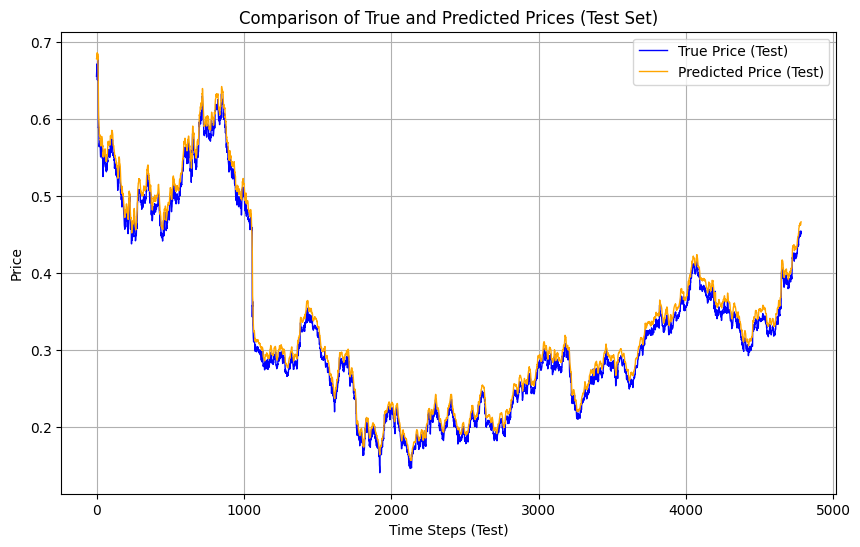

In [ ]:
# 使用MinMaxScaler进行归一化
scaler = MinMaxScaler()
df_all[all_feature_cols] = scaler.fit_transform(df_all[all_feature_cols])

# 数据划分为训练集和测试集（如80%训练，20%测试）
N = len(df_all)
train_ratio = 0.8
train_size = int(N * train_ratio)

train_df = df_all.iloc[:train_size]
test_df = df_all.iloc[train_size:]

train_short_data = train_df[short_cols].values
train_mid_data = train_df[mid_cols].values
train_long_data = train_df[long_cols].values
train_close_15_series = train_df["close_15"].values

test_short_data = test_df[short_cols].values
test_mid_data = test_df[mid_cols].values
test_long_data = test_df[long_cols].values
test_close_15_series = test_df["close_15"].values

seq_len_short = 16
seq_len_mid = 32
seq_len_long = 64

##########################################
# 定义Dataset
##########################################
class MultiScaleStockDataset(Dataset):
    def __init__(self, short_data, mid_data, long_data, close_label,
                 seq_len_short, seq_len_mid, seq_len_long):
        super().__init__()
        self.short_data = short_data
        self.mid_data = mid_data
        self.long_data = long_data
        self.close_label = close_label
        self.seq_len_short = seq_len_short
        self.seq_len_mid = seq_len_mid
        self.seq_len_long = seq_len_long

        self.length = len(short_data) - max(seq_len_short, seq_len_mid, seq_len_long) - 1
        if self.length < 1:
            raise ValueError("Not enough data to form a single sample.")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        start = idx
        end_short = start + self.seq_len_short
        end_mid = start + self.seq_len_mid
        end_long = start + self.seq_len_long

        target_idx = end_short
        short_seq = self.short_data[start:end_short]
        mid_seq = self.mid_data[start:end_mid]
        long_seq = self.long_data[start:end_long]

        label = self.close_label[target_idx]
        # target_seq = torch.zeros(1, short_seq.shape[1])  # decoder输入为0
        # 将 target_seq 设置为短期序列的最后一个时间步的特征，而不是全零
        target_seq = torch.tensor(short_seq[-1], dtype=torch.float32).unsqueeze(0)  # shape: (1, num_features)


        return (torch.tensor(short_seq, dtype=torch.float32),
                torch.tensor(mid_seq, dtype=torch.float32),
                torch.tensor(long_seq, dtype=torch.float32),
                torch.tensor(target_seq, dtype=torch.float32),
                torch.tensor([label], dtype=torch.float32))


train_dataset = MultiScaleStockDataset(train_short_data, train_mid_data, train_long_data, train_close_15_series,
                                       seq_len_short, seq_len_mid, seq_len_long)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = MultiScaleStockDataset(test_short_data, test_mid_data, test_long_data, test_close_15_series,
                                      seq_len_short, seq_len_mid, seq_len_long)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

##########################################
# 模型定义
##########################################
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x

class MultiScaleTransformer(nn.Module):
    def __init__(self,
                 feature_dim,
                 d_model,
                 nhead,
                 num_encoder_layers,
                 num_decoder_layers,
                 output_dim,
                 mlp_hidden_dim=128):
        super(MultiScaleTransformer, self).__init__()

        self.embedding = nn.Linear(feature_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead)

        self.short_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.short_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.mid_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.mid_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.long_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.long_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.conv_fusion = nn.Conv1d(in_channels=3*d_model, out_channels=d_model, kernel_size=1)

        self.mlp = nn.Sequential(
            nn.Linear(d_model, mlp_hidden_dim),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, output_dim)
        )

    def forward(self, short_input, mid_input, long_input, target_seq):
        short_embed = self.embedding(short_input)
        mid_embed = self.embedding(mid_input)
        long_embed = self.embedding(long_input)

        tgt_embed = self.embedding(target_seq)
        tgt_embed = self.pos_encoder(tgt_embed).permute(1,0,2)

        short_embed = self.pos_encoder(short_embed).permute(1,0,2)
        mid_embed = self.pos_encoder(mid_embed).permute(1,0,2)
        long_embed = self.pos_encoder(long_embed).permute(1,0,2)

        short_enc = self.short_encoder(short_embed)
        mid_enc = self.mid_encoder(mid_embed)
        long_enc = self.long_encoder(long_embed)

        short_dec = self.short_decoder(tgt=tgt_embed, memory=short_enc)
        mid_dec = self.mid_decoder(tgt=tgt_embed, memory=mid_enc)
        long_dec = self.long_decoder(tgt=tgt_embed, memory=long_enc)

        short_feat = short_dec[0]
        mid_feat = mid_dec[0]
        long_feat = long_dec[0]

        fusion_feat = torch.cat([short_feat, mid_feat, long_feat], dim=-1)
        fusion_feat = fusion_feat.unsqueeze(-1)
        fusion_feat = self.conv_fusion(fusion_feat)
        fusion_feat = fusion_feat.squeeze(-1)

        output = self.mlp(fusion_feat)
        return output

##########################################
# 训练
##########################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_dim = len(feature_cols) # now 4
d_model = 64
nhead = 4
num_encoder_layers = 2
num_decoder_layers = 2
output_dim = 1
lr = 1e-4
epochs = 10

model = MultiScaleTransformer(feature_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model.train()
for epoch in range(1, epochs+1):
    epoch_loss = 0.0
    batch_count = 0
    for i, (short_seq, mid_seq, long_seq, tgt_seq, label) in enumerate(train_dataloader, start=1):
        short_seq = short_seq.to(device)
        mid_seq = mid_seq.to(device)
        long_seq = long_seq.to(device)
        tgt_seq = tgt_seq.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output = model(short_seq, mid_seq, long_seq, tgt_seq)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * short_seq.size(0)
        batch_count += short_seq.size(0)

    avg_loss = epoch_loss / batch_count
    print(f"Epoch [{epoch}/{epochs}], Average Loss: {avg_loss:.4f}")

##########################################
# 在测试集上进行预测和评估
##########################################
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for (short_seq, mid_seq, long_seq, tgt_seq, label) in test_dataloader:
        short_seq = short_seq.to(device)
        mid_seq = mid_seq.to(device)
        long_seq = long_seq.to(device)
        tgt_seq = tgt_seq.to(device)
        label = label.to(device)

        pred = model(short_seq, mid_seq, long_seq, tgt_seq)
        all_preds.append(pred.cpu().numpy())
        all_labels.append(label.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

num_samples = all_preds.shape[0]
num_features = len(all_feature_cols)
close_15_index = all_feature_cols.index("close_15")

preds_extended = np.zeros((num_samples, num_features))
labels_extended = np.zeros((num_samples, num_features))

preds_extended[:, close_15_index] = all_preds[:, 0]
labels_extended[:, close_15_index] = all_labels[:, 0]

inv_preds = scaler.inverse_transform(preds_extended)[:, close_15_index]
inv_labels = scaler.inverse_transform(labels_extended)[:, close_15_index]

# 计算指标
mse = mean_squared_error(inv_labels, inv_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(inv_labels, inv_preds)
r2 = r2_score(inv_labels, inv_preds)

print("Evaluation Results on Denormalized Scale (Test Set):")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# 画出测试集部分的对比图
plt.figure(figsize=(10,6))
plt.plot(inv_labels, label="True Price (Test)", color='blue', linewidth=1.0)
plt.plot(inv_preds, label="Predicted Price (Test)", color='orange', linewidth=1.0)
plt.title("Comparison of True and Predicted Prices (Test Set)")
plt.xlabel("Time Steps (Test)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
# 可根据需要调整显示范围，例如：
# plt.ylim(20000, 22000)
plt.show()

In [ ]:
NVDA_inv_preds = inv_preds

In [ ]:
NVDA_inv_preds

array([0.68329309, 0.68672327, 0.69123476, ..., 0.46539588, 0.46564329,
       0.4667556 ])

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

##########################################
# 数据读取与处理
##########################################
df = pd.read_csv("/content/drive/MyDrive/CSCO.csv", parse_dates=["DateTime"], index_col="DateTime")
df = df.sort_index()
df = df.ffill()  # 前向填充

df = df[(df.index >= '2000-01-01') & (df.index <= '2010-01-01')]

df.columns = df.columns.str.lower()
feature_cols = ["open", "high", "low", "close", "volume"]

agg_dict = {
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
    "volume": "sum"
}

df_15min = df.resample("15T").agg(agg_dict).dropna(how='any')
df_30min = df.resample("30T").agg(agg_dict).dropna(how='any')
df_60min = df.resample("60T").agg(agg_dict).dropna(how='any')

df_15min = df_15min.rename(columns=lambda c: c.lower()+"_15")
df_30min = df_30min.rename(columns=lambda c: c.lower()+"_30")
df_60min = df_60min.rename(columns=lambda c: c.lower()+"_60")

df_all = df_15min.join(df_30min, how="inner").join(df_60min, how="inner")
print("df_all columns:", df_all.columns)

short_cols = [col+"_15" for col in feature_cols]
mid_cols = [col+"_30" for col in feature_cols]
long_cols = [col+"_60" for col in feature_cols]

all_feature_cols = short_cols + mid_cols + long_cols

<ipython-input-115-82b8f0d02f18>:31: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_15min = df.resample("15T").agg(agg_dict).dropna(how='any')
<ipython-input-115-82b8f0d02f18>:32: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_30min = df.resample("30T").agg(agg_dict).dropna(how='any')
<ipython-input-115-82b8f0d02f18>:33: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_60min = df.resample("60T").agg(agg_dict).dropna(how='any')


df_all columns: Index(['open_15', 'high_15', 'low_15', 'close_15', 'volume_15', 'open_30',
       'high_30', 'low_30', 'close_30', 'volume_30', 'open_60', 'high_60',
       'low_60', 'close_60', 'volume_60'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-116-9454d147e54d>:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(target_seq, dtype=torch.float32),


Epoch [1/10], Average Loss: 0.0011
Epoch [2/10], Average Loss: 0.0002
Epoch [3/10], Average Loss: 0.0001
Epoch [4/10], Average Loss: 0.0001
Epoch [5/10], Average Loss: 0.0001
Epoch [6/10], Average Loss: 0.0001
Epoch [7/10], Average Loss: 0.0001
Epoch [8/10], Average Loss: 0.0001
Epoch [9/10], Average Loss: 0.0001
Epoch [10/10], Average Loss: 0.0001
Evaluation Results on Denormalized Scale (Test Set):
MSE: 0.3554
RMSE: 0.5962
MAE: 0.5694
R²: 0.9708


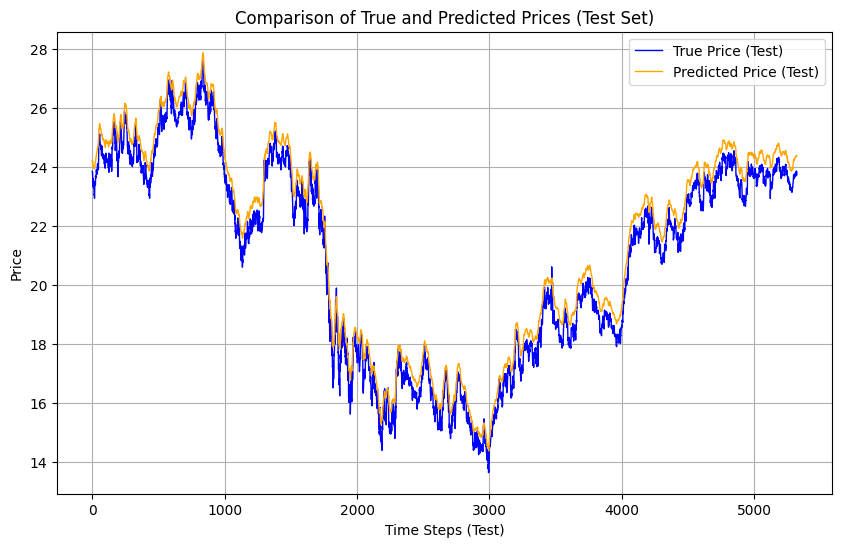

In [ ]:
# 使用MinMaxScaler进行归一化
scaler = MinMaxScaler()
df_all[all_feature_cols] = scaler.fit_transform(df_all[all_feature_cols])

# 数据划分为训练集和测试集（如80%训练，20%测试）
N = len(df_all)
train_ratio = 0.8
train_size = int(N * train_ratio)

train_df = df_all.iloc[:train_size]
test_df = df_all.iloc[train_size:]

train_short_data = train_df[short_cols].values
train_mid_data = train_df[mid_cols].values
train_long_data = train_df[long_cols].values
train_close_15_series = train_df["close_15"].values

test_short_data = test_df[short_cols].values
test_mid_data = test_df[mid_cols].values
test_long_data = test_df[long_cols].values
test_close_15_series = test_df["close_15"].values

seq_len_short = 16
seq_len_mid = 32
seq_len_long = 64

##########################################
# 定义Dataset
##########################################
class MultiScaleStockDataset(Dataset):
    def __init__(self, short_data, mid_data, long_data, close_label,
                 seq_len_short, seq_len_mid, seq_len_long):
        super().__init__()
        self.short_data = short_data
        self.mid_data = mid_data
        self.long_data = long_data
        self.close_label = close_label
        self.seq_len_short = seq_len_short
        self.seq_len_mid = seq_len_mid
        self.seq_len_long = seq_len_long

        self.length = len(short_data) - max(seq_len_short, seq_len_mid, seq_len_long) - 1
        if self.length < 1:
            raise ValueError("Not enough data to form a single sample.")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        start = idx
        end_short = start + self.seq_len_short
        end_mid = start + self.seq_len_mid
        end_long = start + self.seq_len_long

        target_idx = end_short
        short_seq = self.short_data[start:end_short]
        mid_seq = self.mid_data[start:end_mid]
        long_seq = self.long_data[start:end_long]

        label = self.close_label[target_idx]
        # target_seq = torch.zeros(1, short_seq.shape[1])  # decoder输入为0
        # 将 target_seq 设置为短期序列的最后一个时间步的特征，而不是全零
        target_seq = torch.tensor(short_seq[-1], dtype=torch.float32).unsqueeze(0)  # shape: (1, num_features)


        return (torch.tensor(short_seq, dtype=torch.float32),
                torch.tensor(mid_seq, dtype=torch.float32),
                torch.tensor(long_seq, dtype=torch.float32),
                torch.tensor(target_seq, dtype=torch.float32),
                torch.tensor([label], dtype=torch.float32))


train_dataset = MultiScaleStockDataset(train_short_data, train_mid_data, train_long_data, train_close_15_series,
                                       seq_len_short, seq_len_mid, seq_len_long)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = MultiScaleStockDataset(test_short_data, test_mid_data, test_long_data, test_close_15_series,
                                      seq_len_short, seq_len_mid, seq_len_long)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

##########################################
# 模型定义
##########################################
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x

class MultiScaleTransformer(nn.Module):
    def __init__(self,
                 feature_dim,
                 d_model,
                 nhead,
                 num_encoder_layers,
                 num_decoder_layers,
                 output_dim,
                 mlp_hidden_dim=128):
        super(MultiScaleTransformer, self).__init__()

        self.embedding = nn.Linear(feature_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead)

        self.short_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.short_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.mid_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.mid_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.long_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.long_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.conv_fusion = nn.Conv1d(in_channels=3*d_model, out_channels=d_model, kernel_size=1)

        self.mlp = nn.Sequential(
            nn.Linear(d_model, mlp_hidden_dim),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, output_dim)
        )

    def forward(self, short_input, mid_input, long_input, target_seq):
        short_embed = self.embedding(short_input)
        mid_embed = self.embedding(mid_input)
        long_embed = self.embedding(long_input)

        tgt_embed = self.embedding(target_seq)
        tgt_embed = self.pos_encoder(tgt_embed).permute(1,0,2)

        short_embed = self.pos_encoder(short_embed).permute(1,0,2)
        mid_embed = self.pos_encoder(mid_embed).permute(1,0,2)
        long_embed = self.pos_encoder(long_embed).permute(1,0,2)

        short_enc = self.short_encoder(short_embed)
        mid_enc = self.mid_encoder(mid_embed)
        long_enc = self.long_encoder(long_embed)

        short_dec = self.short_decoder(tgt=tgt_embed, memory=short_enc)
        mid_dec = self.mid_decoder(tgt=tgt_embed, memory=mid_enc)
        long_dec = self.long_decoder(tgt=tgt_embed, memory=long_enc)

        short_feat = short_dec[0]
        mid_feat = mid_dec[0]
        long_feat = long_dec[0]

        fusion_feat = torch.cat([short_feat, mid_feat, long_feat], dim=-1)
        fusion_feat = fusion_feat.unsqueeze(-1)
        fusion_feat = self.conv_fusion(fusion_feat)
        fusion_feat = fusion_feat.squeeze(-1)

        output = self.mlp(fusion_feat)
        return output

##########################################
# 训练
##########################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_dim = len(feature_cols) # now 4
d_model = 64
nhead = 4
num_encoder_layers = 2
num_decoder_layers = 2
output_dim = 1
lr = 1e-4
epochs = 10

model = MultiScaleTransformer(feature_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model.train()
for epoch in range(1, epochs+1):
    epoch_loss = 0.0
    batch_count = 0
    for i, (short_seq, mid_seq, long_seq, tgt_seq, label) in enumerate(train_dataloader, start=1):
        short_seq = short_seq.to(device)
        mid_seq = mid_seq.to(device)
        long_seq = long_seq.to(device)
        tgt_seq = tgt_seq.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output = model(short_seq, mid_seq, long_seq, tgt_seq)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * short_seq.size(0)
        batch_count += short_seq.size(0)

    avg_loss = epoch_loss / batch_count
    print(f"Epoch [{epoch}/{epochs}], Average Loss: {avg_loss:.4f}")

##########################################
# 在测试集上进行预测和评估
##########################################
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for (short_seq, mid_seq, long_seq, tgt_seq, label) in test_dataloader:
        short_seq = short_seq.to(device)
        mid_seq = mid_seq.to(device)
        long_seq = long_seq.to(device)
        tgt_seq = tgt_seq.to(device)
        label = label.to(device)

        pred = model(short_seq, mid_seq, long_seq, tgt_seq)
        all_preds.append(pred.cpu().numpy())
        all_labels.append(label.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

num_samples = all_preds.shape[0]
num_features = len(all_feature_cols)
close_15_index = all_feature_cols.index("close_15")

preds_extended = np.zeros((num_samples, num_features))
labels_extended = np.zeros((num_samples, num_features))

preds_extended[:, close_15_index] = all_preds[:, 0]
labels_extended[:, close_15_index] = all_labels[:, 0]

inv_preds = scaler.inverse_transform(preds_extended)[:, close_15_index]
inv_labels = scaler.inverse_transform(labels_extended)[:, close_15_index]

# 计算指标
mse = mean_squared_error(inv_labels, inv_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(inv_labels, inv_preds)
r2 = r2_score(inv_labels, inv_preds)

print("Evaluation Results on Denormalized Scale (Test Set):")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# 画出测试集部分的对比图
plt.figure(figsize=(10,6))
plt.plot(inv_labels, label="True Price (Test)", color='blue', linewidth=1.0)
plt.plot(inv_preds, label="Predicted Price (Test)", color='orange', linewidth=1.0)
plt.title("Comparison of True and Predicted Prices (Test Set)")
plt.xlabel("Time Steps (Test)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
# 可根据需要调整显示范围，例如：
# plt.ylim(20000, 22000)
plt.show()

In [ ]:
CSCO_inv_preds = inv_preds

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

##########################################
# 数据读取与处理
##########################################
df = pd.read_csv("/content/drive/MyDrive/AMD.csv", parse_dates=["DateTime"], index_col="DateTime")
df = df.sort_index()
df = df.ffill()  # 前向填充

df = df[(df.index >= '2000-01-01') & (df.index <= '2010-01-01')]

df.columns = df.columns.str.lower()
feature_cols = ["open", "high", "low", "close", "volume"]

agg_dict = {
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
    "volume": "sum"
}

df_15min = df.resample("15T").agg(agg_dict).dropna(how='any')
df_30min = df.resample("30T").agg(agg_dict).dropna(how='any')
df_60min = df.resample("60T").agg(agg_dict).dropna(how='any')

df_15min = df_15min.rename(columns=lambda c: c.lower()+"_15")
df_30min = df_30min.rename(columns=lambda c: c.lower()+"_30")
df_60min = df_60min.rename(columns=lambda c: c.lower()+"_60")

df_all = df_15min.join(df_30min, how="inner").join(df_60min, how="inner")
print("df_all columns:", df_all.columns)

short_cols = [col+"_15" for col in feature_cols]
mid_cols = [col+"_30" for col in feature_cols]
long_cols = [col+"_60" for col in feature_cols]

all_feature_cols = short_cols + mid_cols + long_cols


<ipython-input-23-52a55f545ee2>:31: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_15min = df.resample("15T").agg(agg_dict).dropna(how='any')
<ipython-input-23-52a55f545ee2>:32: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_30min = df.resample("30T").agg(agg_dict).dropna(how='any')
<ipython-input-23-52a55f545ee2>:33: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_60min = df.resample("60T").agg(agg_dict).dropna(how='any')


df_all columns: Index(['open_15', 'high_15', 'low_15', 'close_15', 'volume_15', 'open_30',
       'high_30', 'low_30', 'close_30', 'volume_30', 'open_60', 'high_60',
       'low_60', 'close_60', 'volume_60'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-26-9454d147e54d>:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(target_seq, dtype=torch.float32),


Epoch [1/10], Average Loss: 0.0017
Epoch [2/10], Average Loss: 0.0002
Epoch [3/10], Average Loss: 0.0002
Epoch [4/10], Average Loss: 0.0002
Epoch [5/10], Average Loss: 0.0002
Epoch [6/10], Average Loss: 0.0001
Epoch [7/10], Average Loss: 0.0001
Epoch [8/10], Average Loss: 0.0001
Epoch [9/10], Average Loss: 0.0001
Epoch [10/10], Average Loss: 0.0001
Evaluation Results on Denormalized Scale (Test Set):
MSE: 0.0297
RMSE: 0.1723
MAE: 0.1450
R²: 0.9901


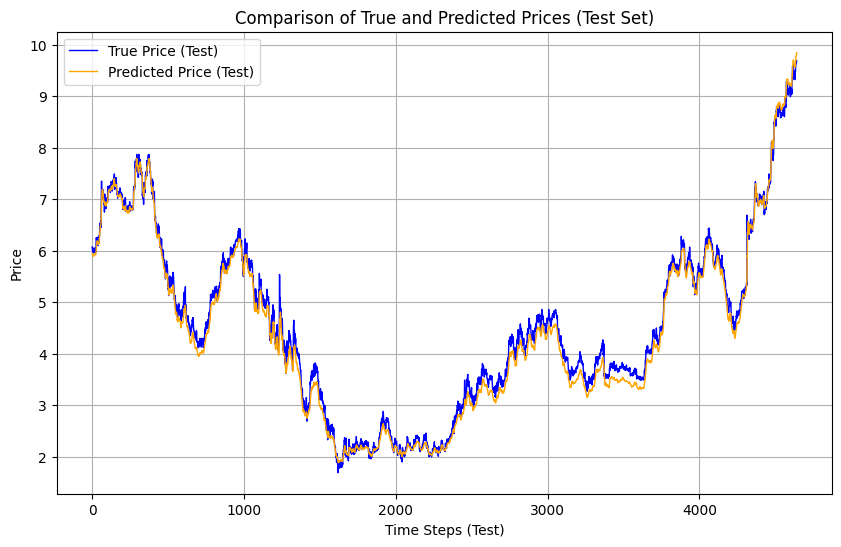

In [ ]:

# 使用MinMaxScaler进行归一化
scaler = MinMaxScaler()
df_all[all_feature_cols] = scaler.fit_transform(df_all[all_feature_cols])

# 数据划分为训练集和测试集（如80%训练，20%测试）
N = len(df_all)
train_ratio = 0.8
train_size = int(N * train_ratio)

train_df = df_all.iloc[:train_size]
test_df = df_all.iloc[train_size:]

train_short_data = train_df[short_cols].values
train_mid_data = train_df[mid_cols].values
train_long_data = train_df[long_cols].values
train_close_15_series = train_df["close_15"].values

test_short_data = test_df[short_cols].values
test_mid_data = test_df[mid_cols].values
test_long_data = test_df[long_cols].values
test_close_15_series = test_df["close_15"].values

seq_len_short = 16
seq_len_mid = 32
seq_len_long = 64

##########################################
# 定义Dataset
##########################################
class MultiScaleStockDataset(Dataset):
    def __init__(self, short_data, mid_data, long_data, close_label,
                 seq_len_short, seq_len_mid, seq_len_long):
        super().__init__()
        self.short_data = short_data
        self.mid_data = mid_data
        self.long_data = long_data
        self.close_label = close_label
        self.seq_len_short = seq_len_short
        self.seq_len_mid = seq_len_mid
        self.seq_len_long = seq_len_long

        self.length = len(short_data) - max(seq_len_short, seq_len_mid, seq_len_long) - 1
        if self.length < 1:
            raise ValueError("Not enough data to form a single sample.")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        start = idx
        end_short = start + self.seq_len_short
        end_mid = start + self.seq_len_mid
        end_long = start + self.seq_len_long

        target_idx = end_short
        short_seq = self.short_data[start:end_short]
        mid_seq = self.mid_data[start:end_mid]
        long_seq = self.long_data[start:end_long]

        label = self.close_label[target_idx]
        # target_seq = torch.zeros(1, short_seq.shape[1])  # decoder输入为0
        # 将 target_seq 设置为短期序列的最后一个时间步的特征，而不是全零
        target_seq = torch.tensor(short_seq[-1], dtype=torch.float32).unsqueeze(0)  # shape: (1, num_features)


        return (torch.tensor(short_seq, dtype=torch.float32),
                torch.tensor(mid_seq, dtype=torch.float32),
                torch.tensor(long_seq, dtype=torch.float32),
                torch.tensor(target_seq, dtype=torch.float32),
                torch.tensor([label], dtype=torch.float32))


train_dataset = MultiScaleStockDataset(train_short_data, train_mid_data, train_long_data, train_close_15_series,
                                       seq_len_short, seq_len_mid, seq_len_long)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = MultiScaleStockDataset(test_short_data, test_mid_data, test_long_data, test_close_15_series,
                                      seq_len_short, seq_len_mid, seq_len_long)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

##########################################
# 模型定义
##########################################
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x

class MultiScaleTransformer(nn.Module):
    def __init__(self,
                 feature_dim,
                 d_model,
                 nhead,
                 num_encoder_layers,
                 num_decoder_layers,
                 output_dim,
                 mlp_hidden_dim=128):
        super(MultiScaleTransformer, self).__init__()

        self.embedding = nn.Linear(feature_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead)

        self.short_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.short_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.mid_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.mid_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.long_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.long_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.conv_fusion = nn.Conv1d(in_channels=3*d_model, out_channels=d_model, kernel_size=1)

        self.mlp = nn.Sequential(
            nn.Linear(d_model, mlp_hidden_dim),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, output_dim)
        )

    def forward(self, short_input, mid_input, long_input, target_seq):
        short_embed = self.embedding(short_input)
        mid_embed = self.embedding(mid_input)
        long_embed = self.embedding(long_input)

        tgt_embed = self.embedding(target_seq)
        tgt_embed = self.pos_encoder(tgt_embed).permute(1,0,2)

        short_embed = self.pos_encoder(short_embed).permute(1,0,2)
        mid_embed = self.pos_encoder(mid_embed).permute(1,0,2)
        long_embed = self.pos_encoder(long_embed).permute(1,0,2)

        short_enc = self.short_encoder(short_embed)
        mid_enc = self.mid_encoder(mid_embed)
        long_enc = self.long_encoder(long_embed)

        short_dec = self.short_decoder(tgt=tgt_embed, memory=short_enc)
        mid_dec = self.mid_decoder(tgt=tgt_embed, memory=mid_enc)
        long_dec = self.long_decoder(tgt=tgt_embed, memory=long_enc)

        short_feat = short_dec[0]
        mid_feat = mid_dec[0]
        long_feat = long_dec[0]

        fusion_feat = torch.cat([short_feat, mid_feat, long_feat], dim=-1)
        fusion_feat = fusion_feat.unsqueeze(-1)
        fusion_feat = self.conv_fusion(fusion_feat)
        fusion_feat = fusion_feat.squeeze(-1)

        output = self.mlp(fusion_feat)
        return output

##########################################
# 训练
##########################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_dim = len(feature_cols) # now 4
d_model = 64
nhead = 4
num_encoder_layers = 2
num_decoder_layers = 2
output_dim = 1
lr = 1e-4
epochs = 10

model = MultiScaleTransformer(feature_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model.train()
for epoch in range(1, epochs+1):
    epoch_loss = 0.0
    batch_count = 0
    for i, (short_seq, mid_seq, long_seq, tgt_seq, label) in enumerate(train_dataloader, start=1):
        short_seq = short_seq.to(device)
        mid_seq = mid_seq.to(device)
        long_seq = long_seq.to(device)
        tgt_seq = tgt_seq.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output = model(short_seq, mid_seq, long_seq, tgt_seq)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * short_seq.size(0)
        batch_count += short_seq.size(0)

    avg_loss = epoch_loss / batch_count
    print(f"Epoch [{epoch}/{epochs}], Average Loss: {avg_loss:.4f}")

##########################################
# 在测试集上进行预测和评估
##########################################
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for (short_seq, mid_seq, long_seq, tgt_seq, label) in test_dataloader:
        short_seq = short_seq.to(device)
        mid_seq = mid_seq.to(device)
        long_seq = long_seq.to(device)
        tgt_seq = tgt_seq.to(device)
        label = label.to(device)

        pred = model(short_seq, mid_seq, long_seq, tgt_seq)
        all_preds.append(pred.cpu().numpy())
        all_labels.append(label.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

num_samples = all_preds.shape[0]
num_features = len(all_feature_cols)
close_15_index = all_feature_cols.index("close_15")

preds_extended = np.zeros((num_samples, num_features))
labels_extended = np.zeros((num_samples, num_features))

preds_extended[:, close_15_index] = all_preds[:, 0]
labels_extended[:, close_15_index] = all_labels[:, 0]

inv_preds = scaler.inverse_transform(preds_extended)[:, close_15_index]
inv_labels = scaler.inverse_transform(labels_extended)[:, close_15_index]

# 计算指标
mse = mean_squared_error(inv_labels, inv_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(inv_labels, inv_preds)
r2 = r2_score(inv_labels, inv_preds)

print("Evaluation Results on Denormalized Scale (Test Set):")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# 画出测试集部分的对比图
plt.figure(figsize=(10,6))
plt.plot(inv_labels, label="True Price (Test)", color='blue', linewidth=1.0)
plt.plot(inv_preds, label="Predicted Price (Test)", color='orange', linewidth=1.0)
plt.title("Comparison of True and Predicted Prices (Test Set)")
plt.xlabel("Time Steps (Test)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
# 可根据需要调整显示范围，例如：
# plt.ylim(20000, 22000)
plt.show()

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

##########################################
# 数据读取与处理
##########################################
df = pd.read_csv("/content/drive/MyDrive/JPM.csv", parse_dates=["DateTime"], index_col="DateTime")
df = df.sort_index()
df = df.ffill()  # 前向填充

df = df[(df.index >= '2000-01-01') & (df.index <= '2010-01-01')]

df.columns = df.columns.str.lower()
feature_cols = ["open", "high", "low", "close", "volume"]

agg_dict = {
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
    "volume": "sum"
}

df_15min = df.resample("15T").agg(agg_dict).dropna(how='any')
df_30min = df.resample("30T").agg(agg_dict).dropna(how='any')
df_60min = df.resample("60T").agg(agg_dict).dropna(how='any')

df_15min = df_15min.rename(columns=lambda c: c.lower()+"_15")
df_30min = df_30min.rename(columns=lambda c: c.lower()+"_30")
df_60min = df_60min.rename(columns=lambda c: c.lower()+"_60")

df_all = df_15min.join(df_30min, how="inner").join(df_60min, how="inner")
print("df_all columns:", df_all.columns)

short_cols = [col+"_15" for col in feature_cols]
mid_cols = [col+"_30" for col in feature_cols]
long_cols = [col+"_60" for col in feature_cols]

all_feature_cols = short_cols + mid_cols + long_cols


<ipython-input-120-89e668472b24>:31: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_15min = df.resample("15T").agg(agg_dict).dropna(how='any')
<ipython-input-120-89e668472b24>:32: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_30min = df.resample("30T").agg(agg_dict).dropna(how='any')
<ipython-input-120-89e668472b24>:33: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_60min = df.resample("60T").agg(agg_dict).dropna(how='any')


df_all columns: Index(['open_15', 'high_15', 'low_15', 'close_15', 'volume_15', 'open_30',
       'high_30', 'low_30', 'close_30', 'volume_30', 'open_60', 'high_60',
       'low_60', 'close_60', 'volume_60'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-121-9454d147e54d>:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(target_seq, dtype=torch.float32),


Epoch [1/10], Average Loss: 0.0011
Epoch [2/10], Average Loss: 0.0002
Epoch [3/10], Average Loss: 0.0002
Epoch [4/10], Average Loss: 0.0001
Epoch [5/10], Average Loss: 0.0001
Epoch [6/10], Average Loss: 0.0001
Epoch [7/10], Average Loss: 0.0001
Epoch [8/10], Average Loss: 0.0001
Epoch [9/10], Average Loss: 0.0001
Epoch [10/10], Average Loss: 0.0001
Evaluation Results on Denormalized Scale (Test Set):
MSE: 1.3268
RMSE: 1.1519
MAE: 1.0856
R²: 0.9753


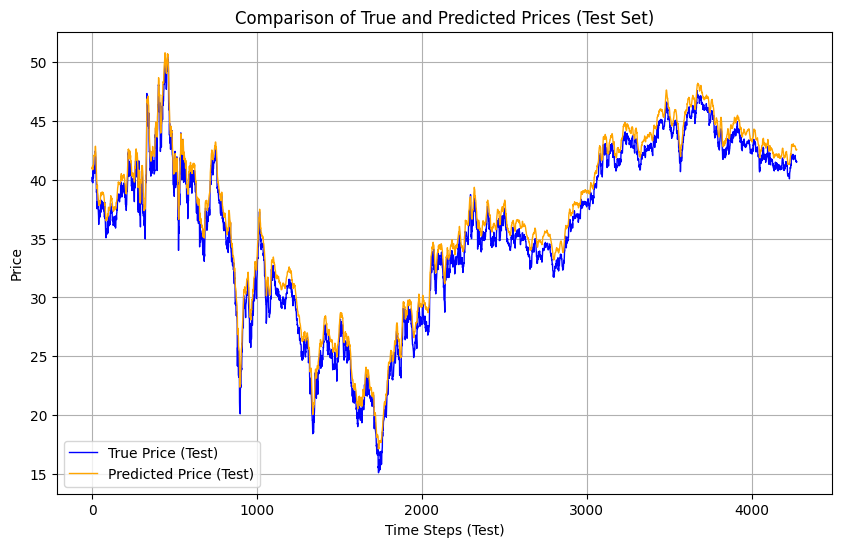

In [ ]:

# 使用MinMaxScaler进行归一化
scaler = MinMaxScaler()
df_all[all_feature_cols] = scaler.fit_transform(df_all[all_feature_cols])

# 数据划分为训练集和测试集（如80%训练，20%测试）
N = len(df_all)
train_ratio = 0.8
train_size = int(N * train_ratio)

train_df = df_all.iloc[:train_size]
test_df = df_all.iloc[train_size:]

train_short_data = train_df[short_cols].values
train_mid_data = train_df[mid_cols].values
train_long_data = train_df[long_cols].values
train_close_15_series = train_df["close_15"].values

test_short_data = test_df[short_cols].values
test_mid_data = test_df[mid_cols].values
test_long_data = test_df[long_cols].values
test_close_15_series = test_df["close_15"].values

seq_len_short = 16
seq_len_mid = 32
seq_len_long = 64

##########################################
# 定义Dataset
##########################################
class MultiScaleStockDataset(Dataset):
    def __init__(self, short_data, mid_data, long_data, close_label,
                 seq_len_short, seq_len_mid, seq_len_long):
        super().__init__()
        self.short_data = short_data
        self.mid_data = mid_data
        self.long_data = long_data
        self.close_label = close_label
        self.seq_len_short = seq_len_short
        self.seq_len_mid = seq_len_mid
        self.seq_len_long = seq_len_long

        self.length = len(short_data) - max(seq_len_short, seq_len_mid, seq_len_long) - 1
        if self.length < 1:
            raise ValueError("Not enough data to form a single sample.")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        start = idx
        end_short = start + self.seq_len_short
        end_mid = start + self.seq_len_mid
        end_long = start + self.seq_len_long

        target_idx = end_short
        short_seq = self.short_data[start:end_short]
        mid_seq = self.mid_data[start:end_mid]
        long_seq = self.long_data[start:end_long]

        label = self.close_label[target_idx]
        # target_seq = torch.zeros(1, short_seq.shape[1])  # decoder输入为0
        # 将 target_seq 设置为短期序列的最后一个时间步的特征，而不是全零
        target_seq = torch.tensor(short_seq[-1], dtype=torch.float32).unsqueeze(0)  # shape: (1, num_features)


        return (torch.tensor(short_seq, dtype=torch.float32),
                torch.tensor(mid_seq, dtype=torch.float32),
                torch.tensor(long_seq, dtype=torch.float32),
                torch.tensor(target_seq, dtype=torch.float32),
                torch.tensor([label], dtype=torch.float32))


train_dataset = MultiScaleStockDataset(train_short_data, train_mid_data, train_long_data, train_close_15_series,
                                       seq_len_short, seq_len_mid, seq_len_long)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = MultiScaleStockDataset(test_short_data, test_mid_data, test_long_data, test_close_15_series,
                                      seq_len_short, seq_len_mid, seq_len_long)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

##########################################
# 模型定义
##########################################
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x

class MultiScaleTransformer(nn.Module):
    def __init__(self,
                 feature_dim,
                 d_model,
                 nhead,
                 num_encoder_layers,
                 num_decoder_layers,
                 output_dim,
                 mlp_hidden_dim=128):
        super(MultiScaleTransformer, self).__init__()

        self.embedding = nn.Linear(feature_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead)

        self.short_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.short_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.mid_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.mid_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.long_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.long_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.conv_fusion = nn.Conv1d(in_channels=3*d_model, out_channels=d_model, kernel_size=1)

        self.mlp = nn.Sequential(
            nn.Linear(d_model, mlp_hidden_dim),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, output_dim)
        )

    def forward(self, short_input, mid_input, long_input, target_seq):
        short_embed = self.embedding(short_input)
        mid_embed = self.embedding(mid_input)
        long_embed = self.embedding(long_input)

        tgt_embed = self.embedding(target_seq)
        tgt_embed = self.pos_encoder(tgt_embed).permute(1,0,2)

        short_embed = self.pos_encoder(short_embed).permute(1,0,2)
        mid_embed = self.pos_encoder(mid_embed).permute(1,0,2)
        long_embed = self.pos_encoder(long_embed).permute(1,0,2)

        short_enc = self.short_encoder(short_embed)
        mid_enc = self.mid_encoder(mid_embed)
        long_enc = self.long_encoder(long_embed)

        short_dec = self.short_decoder(tgt=tgt_embed, memory=short_enc)
        mid_dec = self.mid_decoder(tgt=tgt_embed, memory=mid_enc)
        long_dec = self.long_decoder(tgt=tgt_embed, memory=long_enc)

        short_feat = short_dec[0]
        mid_feat = mid_dec[0]
        long_feat = long_dec[0]

        fusion_feat = torch.cat([short_feat, mid_feat, long_feat], dim=-1)
        fusion_feat = fusion_feat.unsqueeze(-1)
        fusion_feat = self.conv_fusion(fusion_feat)
        fusion_feat = fusion_feat.squeeze(-1)

        output = self.mlp(fusion_feat)
        return output

##########################################
# 训练
##########################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_dim = len(feature_cols) # now 4
d_model = 64
nhead = 4
num_encoder_layers = 2
num_decoder_layers = 2
output_dim = 1
lr = 1e-4
epochs = 10

model = MultiScaleTransformer(feature_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model.train()
for epoch in range(1, epochs+1):
    epoch_loss = 0.0
    batch_count = 0
    for i, (short_seq, mid_seq, long_seq, tgt_seq, label) in enumerate(train_dataloader, start=1):
        short_seq = short_seq.to(device)
        mid_seq = mid_seq.to(device)
        long_seq = long_seq.to(device)
        tgt_seq = tgt_seq.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output = model(short_seq, mid_seq, long_seq, tgt_seq)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * short_seq.size(0)
        batch_count += short_seq.size(0)

    avg_loss = epoch_loss / batch_count
    print(f"Epoch [{epoch}/{epochs}], Average Loss: {avg_loss:.4f}")

##########################################
# 在测试集上进行预测和评估
##########################################
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for (short_seq, mid_seq, long_seq, tgt_seq, label) in test_dataloader:
        short_seq = short_seq.to(device)
        mid_seq = mid_seq.to(device)
        long_seq = long_seq.to(device)
        tgt_seq = tgt_seq.to(device)
        label = label.to(device)

        pred = model(short_seq, mid_seq, long_seq, tgt_seq)
        all_preds.append(pred.cpu().numpy())
        all_labels.append(label.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

num_samples = all_preds.shape[0]
num_features = len(all_feature_cols)
close_15_index = all_feature_cols.index("close_15")

preds_extended = np.zeros((num_samples, num_features))
labels_extended = np.zeros((num_samples, num_features))

preds_extended[:, close_15_index] = all_preds[:, 0]
labels_extended[:, close_15_index] = all_labels[:, 0]

inv_preds = scaler.inverse_transform(preds_extended)[:, close_15_index]
inv_labels = scaler.inverse_transform(labels_extended)[:, close_15_index]

# 计算指标
mse = mean_squared_error(inv_labels, inv_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(inv_labels, inv_preds)
r2 = r2_score(inv_labels, inv_preds)

print("Evaluation Results on Denormalized Scale (Test Set):")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# 画出测试集部分的对比图
plt.figure(figsize=(10,6))
plt.plot(inv_labels, label="True Price (Test)", color='blue', linewidth=1.0)
plt.plot(inv_preds, label="Predicted Price (Test)", color='orange', linewidth=1.0)
plt.title("Comparison of True and Predicted Prices (Test Set)")
plt.xlabel("Time Steps (Test)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
# 可根据需要调整显示范围，例如：
# plt.ylim(20000, 22000)
plt.show()

In [ ]:
JPM_inv_preds = inv_preds

In [ ]:
Nasdaq_100_inv_preds

array([ 6.80246428e-02,  6.40147105e-02,  4.10839841e-02,  2.32645571e-02,
        1.56827010e-02,  1.71142220e-02,  2.51657888e-02,  3.66180018e-02,
        6.11818805e-02,  9.48433504e-02,  1.16119884e-01,  1.24940313e-01,
        1.28286958e-01,  1.31030589e-01,  1.31321371e-01,  1.30711734e-01,
        1.30194575e-01,  1.34103566e-01,  1.38212591e-01,  1.34794116e-01,
        1.30337924e-01,  1.28241181e-01,  1.21387996e-01,  8.90078172e-02,
        6.05811402e-02,  4.96799648e-02,  4.68732342e-02,  4.83739153e-02,
        5.13256192e-02,  4.21943218e-02, -7.15542212e-03, -4.51926850e-02,
       -5.99898919e-02, -6.84179217e-02, -7.53475353e-02, -8.02556053e-02,
       -7.75520802e-02, -6.48911446e-02, -5.05213216e-02, -3.87765504e-02,
       -3.22084650e-02, -2.75554471e-02, -2.44332477e-02, -2.37439834e-02,
       -2.55576968e-02, -1.61731988e-02, -3.36967409e-04,  1.44673400e-02,
        2.16986984e-02,  2.65977979e-02,  3.89711037e-02,  5.86252287e-02,
        6.89495429e-02,  

In [ ]:
Nasdaq_100_return = np.log(pd.Series(Nasdaq_100_inv_preds)/ pd.Series(Nasdaq_100_inv_preds).shift(1))

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
len(Nasdaq_100_inv_preds)

649

In [ ]:
AMD_inv_preds = inv_preds

In [ ]:
AMD_log_returns = np.log(pd.Series(AMD_inv_preds)/ pd.Series(AMD_inv_preds).shift(1))


In [ ]:
AMD_inv_preds

array([5.94329636, 5.93473799, 5.92143675, ..., 9.80630075, 9.81870195,
       9.84335007])

In [ ]:
AMD_log_returns = np.log(pd.Series(AMD_inv_preds[-649:])/ pd.Series(AMD_inv_preds[-649:]).shift(1))
AMD_Price_correlation = pd.Series(Nasdaq_100_inv_preds[-649:]).corr(pd.Series(AMD_inv_preds[-649:]))
AMD_return_correlation = pd.Series(Nasdaq_100_return).corr(pd.Series(AMD_log_returns))
AMD_correlation_metric = [AMD_Price_correlation,AMD_return_correlation]
print(AMD_correlation_metric)

[-0.03627223314740809, 0.1066579742525969]


In [ ]:
APPL_log_returns = np.log(pd.Series(APPL_inv_preds[-649:])/ pd.Series(APPL_inv_preds[-649:]).shift(1))
APPL_Price_correlation = pd.Series(Nasdaq_100_inv_preds).corr(pd.Series(APPL_inv_preds[-649:]))
APPL_return_correlation = pd.Series(Nasdaq_100_return).corr(pd.Series(APPL_log_returns))
APPL_correlation_metric = [APPL_Price_correlation,APPL_return_correlation]
print(APPL_correlation_metric)

[-0.017412921467107708, 0.04105987129261149]


In [ ]:
PEP_log_returns = np.log(pd.Series(PEP_inv_preds[-649:])/ pd.Series(PEP_inv_preds[-649:]).shift(1))
PEP_Price_correlation = pd.Series(Nasdaq_100_inv_preds).corr(pd.Series(PEP_inv_preds[-649:]))
PEP_return_correlation = pd.Series(Nasdaq_100_return).corr(pd.Series(PEP_log_returns))
PEP_correlation_metric = [PEP_Price_correlation,PEP_return_correlation]
print(PEP_correlation_metric)

[0.7177967634432868, -0.04539089563793482]


In [ ]:
NVDA_log_returns = np.log(pd.Series(NVDA_inv_preds[-649:])/ pd.Series(NVDA_inv_preds[-649:]).shift(1))
NVDA_Price_correlation = pd.Series(Nasdaq_100_inv_preds).corr(pd.Series(NVDA_inv_preds[-649:]))
NVDA_return_correlation = pd.Series(Nasdaq_100_return).corr(pd.Series(NVDA_log_returns))
NVDA_correlation_metric = [NVDA_Price_correlation,NVDA_return_correlation]
print(NVDA_correlation_metric)

[0.257943459869111, -0.023948417958101584]


In [ ]:
CSCO_log_returns = np.log(pd.Series(CSCO_inv_preds[-649:])/ pd.Series(CSCO_inv_preds[-649:]).shift(1))
CSCO_Price_correlation = pd.Series(Nasdaq_100_inv_preds).corr(pd.Series(CSCO_inv_preds[-649:]))
CSCO_return_correlation = pd.Series(Nasdaq_100_return).corr(pd.Series(CSCO_log_returns))
CSCO_correlation_metric = [CSCO_Price_correlation,CSCO_return_correlation]
print(CSCO_correlation_metric)

[-0.04372701453095428, 0.05382540213517941]


In [ ]:
JPM_log_returns = np.log(pd.Series(JPM_inv_preds[-649:])/ pd.Series(JPM_inv_preds[-649:]).shift(1))
JPM_Price_correlation = pd.Series(Nasdaq_100_inv_preds).corr(pd.Series(JPM_inv_preds[-649:]))
JPM_return_correlation = pd.Series(Nasdaq_100_return).corr(pd.Series(JPM_log_returns))
JPM_correlation_metric = [JPM_Price_correlation,JPM_return_correlation]
print(JPM_correlation_metric)

[-0.8772635806522959, -0.033734168490156]


Cluster labels: [1 1 0 0 1]


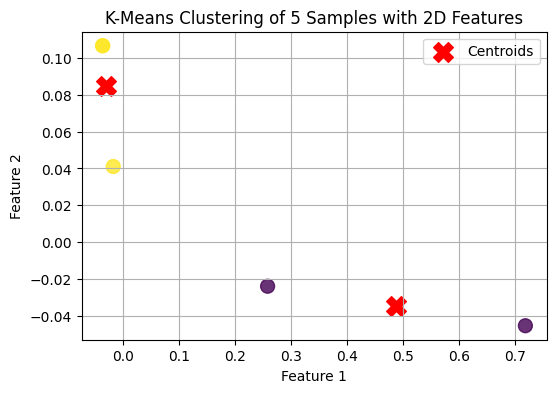

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 假设您已有5个二位特征向量，如：
# 例如下面是虚拟数据，仅作示例


# 将5个2D特征堆叠成矩阵X，形状为 (5, 2)
X = np.array([AMD_correlation_metric, APPL_correlation_metric, PEP_correlation_metric, NVDA_correlation_metric, CSCO_correlation_metric])

# 指定聚类数k，例如k=2或3
k = 2
kmeans = KMeans(n_clusters=k, random_state=123)
cluster_labels = kmeans.fit_predict(X)

print("Cluster labels:", cluster_labels)

# 可视化
plt.figure(figsize=(6,4))
plt.scatter(X[:,0], X[:,1], c=cluster_labels, cmap='viridis', s=100, alpha=0.8)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
            c='red', s=200, marker='X', label='Centroids')
plt.title("K-Means Clustering of 5 Samples with 2D Features")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
X = np.array([AMD_correlation_metric, APPL_correlation_metric, PEP_correlation_metric, NVDA_correlation_metric, CSCO_correlation_metric, JPM_correlation_metric ])
print(X)

[[-0.03627223  0.10665797]
 [-0.01741292  0.04105987]
 [ 0.71779676 -0.0453909 ]
 [ 0.25794346 -0.02394842]
 [-0.04372701  0.0538254 ]
 [-0.87726358 -0.03373417]]


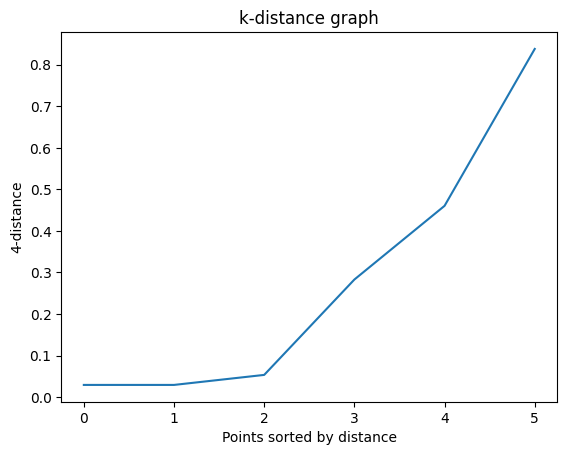

Estimated number of clusters: 1


<ipython-input-131-9ece2dabdacf>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Spectral')(np.linspace(0,1,len(unique_labels)))


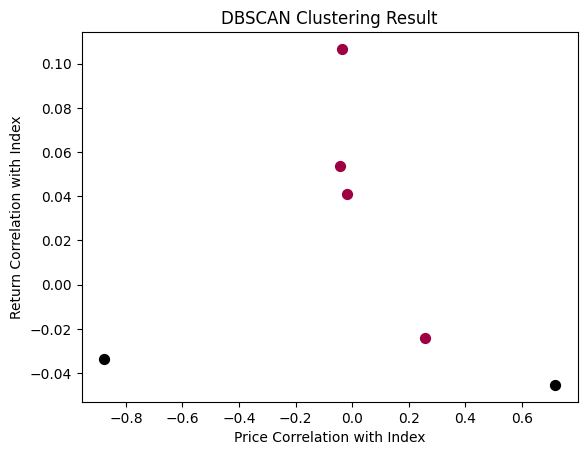

In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# 假设X是您的特征矩阵 (n_samples, n_features)
# X = np.array([...])

# 首先尝试使用k-距离图寻找eps
# 假设min_samples=5， 则k = min_samples-1 = 4
min_samples = 2
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)

# distances是 (n_samples, min_samples)，对每行的第k列取其第k距离
# 排除第0列(自身距离为0)
k_distances = distances[:, min_samples-1]
k_distances_sorted = np.sort(k_distances)

plt.figure()
plt.plot(k_distances_sorted)
plt.title("k-distance graph")
plt.xlabel("Points sorted by distance")
plt.ylabel("4-distance") # 如果min_samples=5，则k=4
plt.show()

# 从图中观察肘部位置选择适合的eps值
# 假设您从图中判断eps约为0.5(根据数据分布自行调整)
eps = 0.3

# 使用DBSCAN聚类
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
cluster_labels = dbscan.fit_predict(X)

# 分析结果
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f"Estimated number of clusters: {n_clusters}")

# 可视化（如X为2D, 否则需要降维）
if X.shape[1] == 2:
    plt.figure()
    unique_labels = set(cluster_labels)
    colors = plt.cm.get_cmap('Spectral')(np.linspace(0,1,len(unique_labels)))
    for (label, col) in zip(unique_labels, colors):
        if label == -1:
            # 噪声点为黑色
            col = [0,0,0,1]
        class_member_mask = (cluster_labels == label)
        plt.scatter(X[class_member_mask, 0], X[class_member_mask, 1], c=[col], s=50)
    plt.title("DBSCAN Clustering Result")
    plt.xlabel('Price Correlation with Index')
    plt.ylabel('Return Correlation with Index')
    plt.show()


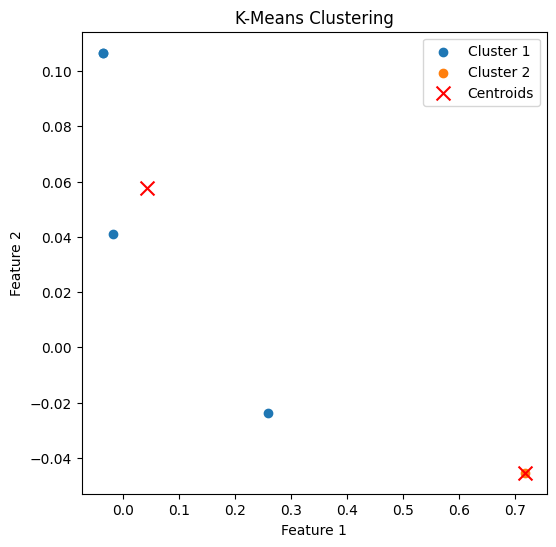

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 输入数据
data = np.array([
    [-0.03627223,  0.10665797],
    [-0.01741292,  0.04105987],
    [ 0.71779676, -0.0453909 ],
    [ 0.25794346, -0.02394842],
    [-0.03627223,  0.10665797]
])

# 设置聚类簇的数量
n_clusters = 2

# 初始化并拟合 KMeans 模型
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(data)

# 获取聚类标签和质心
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# 可视化聚类结果
plt.figure(figsize=(6, 6))
for i in range(n_clusters):
    plt.scatter(data[labels == i][:, 0], data[labels == i][:, 1], label=f'Cluster {i+1}')
plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c='red', marker='x', label='Centroids')
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


      Price_correlation  Return_correlation
AMD             -0.0367              0.1067
APPL            -0.0174              0.0411
PEP              0.7179             -0.0453
NVDA             0.2579             -0.0239
CSCO            -0.0437              0.0538
JPM             -0.8773             -0.0337


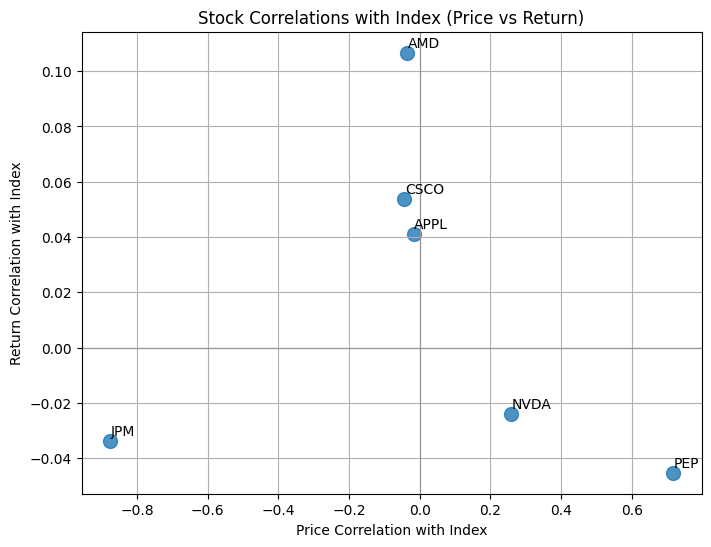

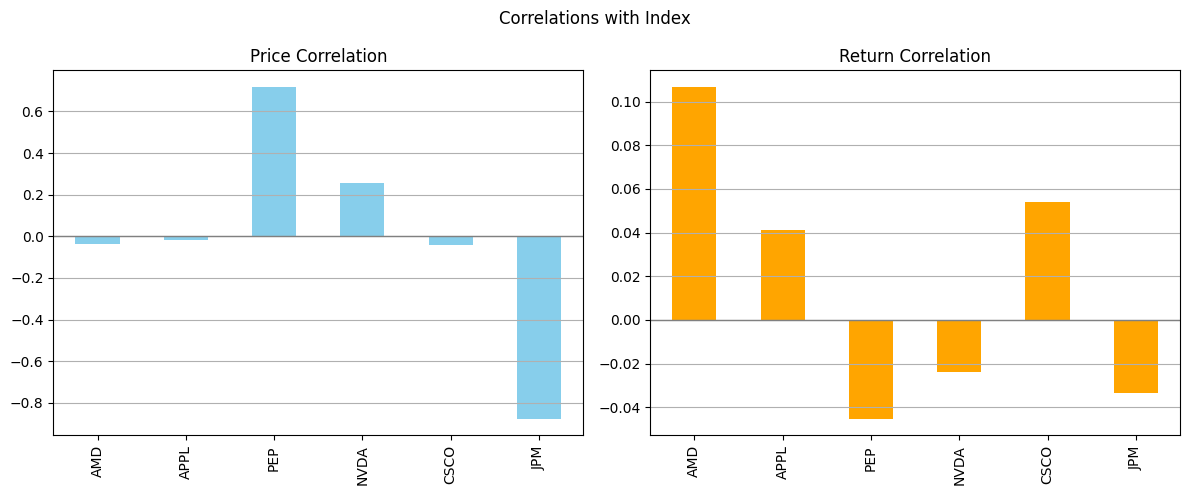

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设您已经得到如下的相关性数据（Price_correlation, Return_correlation）
# 这里是示例值，请将其替换为实际计算结果
correlation_data = {
    'AMD': [-0.0367, 0.1067],    # [Price_correlation, Return_correlation]
    'APPL': [-0.0174, 0.0411],
    'PEP': [0.7179, -0.0453],
    'NVDA': [0.2579, -0.0239],
    'CSCO': [-0.0437, 0.0538],
    'JPM': [-0.8773, -0.0337]
}

# 将数据转换为DataFrame
df = pd.DataFrame.from_dict(correlation_data, orient='index', columns=['Price_correlation', 'Return_correlation'])
print(df)

# 方法一：绘制散点图
plt.figure(figsize=(8,6))
plt.scatter(df['Price_correlation'], df['Return_correlation'], s=100, alpha=0.8)

for stock in df.index:
    x = df.loc[stock, 'Price_correlation']
    y = df.loc[stock, 'Return_correlation']
    plt.text(x+0.002, y+0.002, stock, fontsize=10)

plt.axhline(0, color='grey', linewidth=1, alpha=0.5)
plt.axvline(0, color='grey', linewidth=1, alpha=0.5)
plt.xlabel('Price Correlation with Index')
plt.ylabel('Return Correlation with Index')
plt.title('Stock Correlations with Index (Price vs Return)')
plt.grid(True)
plt.show()

# 方法二：绘制柱状图（分为两个子图）
fig, axes = plt.subplots(1,2, figsize=(12,5))

df['Price_correlation'].plot(kind='bar', ax=axes[0], color='skyblue', title='Price Correlation')
axes[0].axhline(0, color='grey', linewidth=1)
axes[0].grid(axis='y')

df['Return_correlation'].plot(kind='bar', ax=axes[1], color='orange', title='Return Correlation')
axes[1].axhline(0, color='grey', linewidth=1)
axes[1].grid(axis='y')

plt.suptitle('Correlations with Index')
plt.tight_layout()
plt.show()


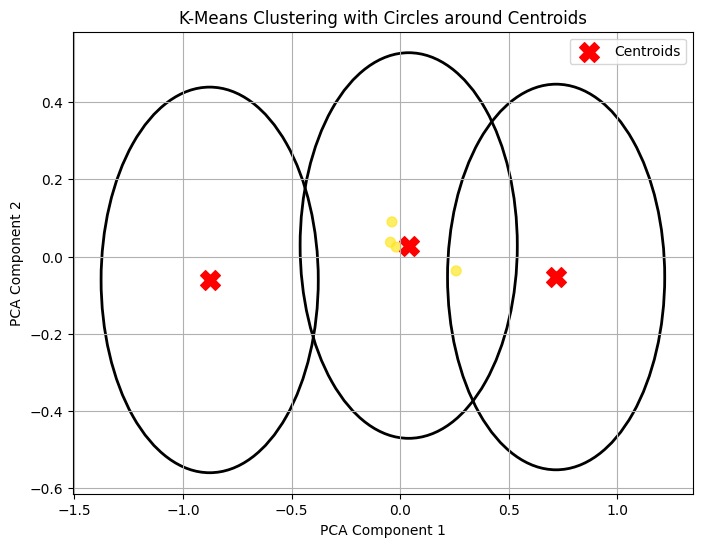

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib.patches import Circle

# 假设X是您的特征矩阵 shape=(n_samples, n_features)
# X = np.array([...])

# 聚类 (指定簇数k)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

# PCA降维到2D以便可视化（如X原始维数大于2）
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# 将聚类中心也投影到2D空间
centroids_2d = pca.transform(centroids)

plt.figure(figsize=(8,6))
# 绘制样本点，根据cluster labels着色
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap='viridis', s=50, alpha=0.7)

# 绘制聚类中心
plt.scatter(centroids_2d[:,0], centroids_2d[:,1], c='red', s=200, marker='X', label='Centroids')

# 为每个簇在中心附近添加一个圆圈
# 半径可根据数据分布调整，这里假设一个固定半径0.5作为示例
for i in range(k):
    circle = Circle((centroids_2d[i,0], centroids_2d[i,1]), radius=0.5, fill=False, edgecolor='black', linewidth=2)
    plt.gca().add_patch(circle)

plt.title("K-Means Clustering with Circles around Centroids")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()


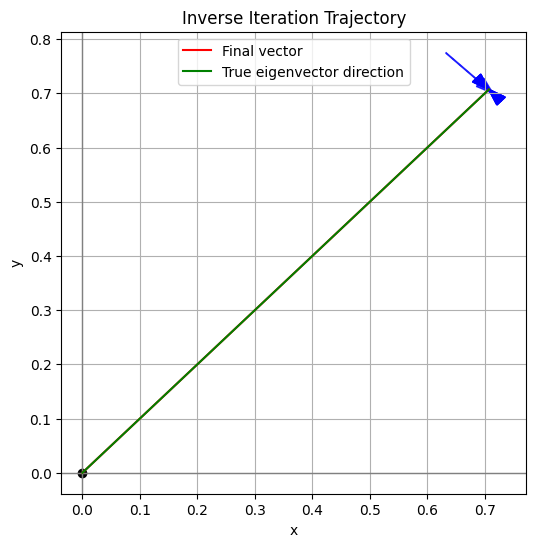

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 定义一个有两个特征值的简单矩阵
A = np.array([[2, 1],
              [0, 3]])

# 理论上A的特征值是3和2
# 最大特征值为3，对应的特征向量方向可用: (1,1) 或归一化后约(0.707,0.707)
true_eigvector = np.array([1, 1])
true_eigvector = true_eigvector / np.linalg.norm(true_eigvector)

# 选择sigma接近3，例如 2.9
sigma = 2.9
ASigma = A - sigma * np.eye(2)  # A - sigma I 矩阵

# 初始向量随机给定
x = np.random.rand(2)
x = x / np.linalg.norm(x)

# 迭代次数
num_iterations = 10

# 用于可视化存储迭代向量
vectors = [x.copy()]

for i in range(num_iterations):
    # 解线性方程 (A - sigma I) y = x
    # y = (A - sigma I)^{-1} x
    y = np.linalg.solve(ASigma, x)
    # 归一化
    x = y / np.linalg.norm(y)
    vectors.append(x.copy())

# 可视化
plt.figure(figsize=(6,6))
plt.axhline(0, color='grey', linewidth=1)
plt.axvline(0, color='grey', linewidth=1)
plt.grid(True)

# 绘制迭代向量的轨迹
for i in range(len(vectors)-1):
    # 从vectors[i]指向vectors[i+1]画箭头
    start = vectors[i]
    end = vectors[i+1]
    plt.arrow(start[0], start[1], end[0]-start[0], end[1]-start[1],
              head_width=0.02, length_includes_head=True,
              color='blue', alpha=0.8)

# 画出最终方向、真实特征向量方向
# 最终x值
final_x = vectors[-1]

plt.scatter([0],[0], color='black') # 原点
plt.plot([0, final_x[0]], [0, final_x[1]], color='red', label='Final vector')
plt.plot([0, true_eigvector[0]], [0, true_eigvector[1]], color='green', label='True eigenvector direction')
plt.title("Inverse Iteration Trajectory")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()
